In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RegNet(nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        self.fc1 = nn.Linear(1000,1000)
        self.fc2 = nn.Linear(1000,1000)
        self.fc3 = nn.Linear(1000,1,bias=False)
        self.dropout = nn.Dropout(0.25)
        self.thr = nn.Sigmoid()
        self.thr1 = nn.ReLU()
        self.thr2 = nn.LeakyReLU(0.1)

    def forward(self,x):
        #x=self.thr2(self.fc1(x))
        x=self.thr2(self.fc2(x))
        x=self.thr(self.fc3(x))
        return x 

import hdf5storage
mat = hdf5storage.loadmat('wrongsource.mat') 
import torch
import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pylab as plt
import pickle
import scipy.io as sio
dtype = torch.double
device = torch.device("cpu")


H_right=mat['source']
H_wrong=mat['wsource']

#Convert into torch arrays
Hr=torch.from_numpy(H_right)
Hw=torch.from_numpy(H_wrong)

nValidation=100
nTrain=Hr.shape[1]-nValidation

print(nTrain)
#Hr=Hr[:,0:500]
#Hw=Hw[:,0:500]
# initial scrambling 
perm = torch.randperm(nTrain+nValidation)
Hr = Hr[:,perm]
Hw = Hw[:,perm]

# validation dataset
val_r = Hr[:,-nValidation:]
val_w = Hw[:,-nValidation:]


N=50
nEpochs=100

net1 = RegNet()
net1 = net1.float()

# Loss and optimizer
learning_rate = 4e-4
optimizer = torch.optim.SGD(net1.parameters(), lr=learning_rate)


#with torch.no_grad():
#    net1.fc2.weight.data = torch.abs(net1.fc2.weight.data)/torch.norm(net1.fc2.weight.data,2)


beta=0.0007
beta1=0.0007
beta5 = 0.0002
for t in range(nEpochs):
    tloss=0
    ndloss=0
    sploss = 0
    perm = torch.randperm(nTrain)
    for b_ix in np.arange(0,nTrain,N):
        
        
        ##Pre-processing sparse codes for input 
        #xr=Hr[:,perm[b_ix:b_ix+N]].reshape(N,Hr.shape[0])
        #xw=Hw[:,perm[b_ix:b_ix+N]].reshape(N,Hw.shape[0])
        xr=Hr[:,perm[b_ix:b_ix+N]].T
        xw=Hw[:,perm[b_ix:b_ix+N]].T
        optimizer.zero_grad()
    
        normr = net1(xr.float())
        normw = net1(xw.float())
        spp = beta5 *torch.abs((normr - torch.abs(torch.sum(xr,1)))).sum()
        ndiff = (normr-normw).sum() 
        
        
        #loss1 = (normr-normw).sum() + beta5*torch.abs((normr.sum()-torch.sum(torch.abs(xr))))#/(N*(torch.max(torch.abs(normw-normr)))) # + beta*torch.norm(net1.fc2.weight.data,2) + beta1*torch.norm(net1.fc1.weight.data,2)
        loss1 =  ndiff #+ spp
        
        
       
        # Backward and optimize
        
        loss1.backward()
        optimizer.step()
        
        #for p in net1.parameters():
        #    p.data.clamp_(0)
        #with torch.no_grad():
        #    net1.fc1.weight.data = self.thr(net1.fc1.weight.data)  ##Projecting the weights to positive
        #    net1.fc2.weight.data = self.thr(net1.fc2.weight.data)
        tloss=tloss+loss1
        #ndloss = ndloss + ndiff
        #sploss = sploss + spp
        
        
        with torch.no_grad():
            #loss = (normw-normr).sum()/(N*(torch.max(torch.abs(normw-normr))))
            #tl=tl+loss

                
            if b_ix / N == (nTrain/N)-1:
                print('Epoch:{:d}| Average Epoch loss:{:.20f}'.format(t+1, tloss/(nTrain/N)))
                print(net1.fc1.weight.sum())
                print(net1.fc2.weight.sum())
                

9900
Epoch:1| Average Epoch loss:-40.35185241699218750000
tensor(-1.5536)
tensor(-74.5214)
Epoch:2| Average Epoch loss:-46.87392044067382812500
tensor(-1.5536)
tensor(-87.1205)
Epoch:3| Average Epoch loss:-47.71726989746093750000
tensor(-1.5536)
tensor(-93.3190)
Epoch:4| Average Epoch loss:-48.20489120483398437500
tensor(-1.5536)
tensor(-98.1512)
Epoch:5| Average Epoch loss:-48.46812438964843750000
tensor(-1.5536)
tensor(-101.8961)
Epoch:6| Average Epoch loss:-48.62799453735351562500
tensor(-1.5536)
tensor(-105.6056)
Epoch:7| Average Epoch loss:-48.71174240112304687500
tensor(-1.5536)
tensor(-110.5853)
Epoch:8| Average Epoch loss:-48.78762817382812500000
tensor(-1.5536)
tensor(-111.1803)
Epoch:9| Average Epoch loss:-48.83580780029296875000
tensor(-1.5536)
tensor(-113.6492)
Epoch:10| Average Epoch loss:-48.83592605590820312500
tensor(-1.5536)
tensor(-118.6432)
Epoch:11| Average Epoch loss:-48.91365814208984375000
tensor(-1.5536)
tensor(-123.3212)
Epoch:12| Average Epoch loss:-48.9259948

KeyboardInterrupt: 

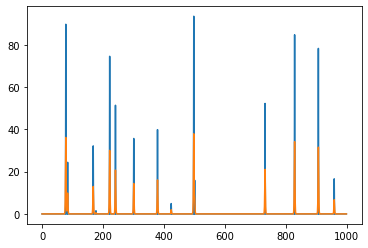

In [14]:
plt.plot(Hr[:,45])
plt.plot(Hw[:,45])

In [20]:
net1.fc2.weight

Parameter containing:
tensor([[ 1.8121e-03,  2.1856e-02, -6.9327e-03,  ..., -3.5432e-05,
         -9.7260e-03, -2.5050e-02],
        [ 1.5824e-02,  2.0094e-02,  2.1515e-02,  ...,  1.4321e-02,
         -2.6423e-02, -2.5400e-02],
        [ 1.7304e-02,  2.3956e-02,  2.0584e-02,  ..., -1.9776e-02,
         -2.9938e-02, -1.4612e-02],
        ...,
        [-1.4997e-02, -2.4060e-02, -3.0214e-02,  ...,  2.0906e-02,
         -5.5219e-03, -2.3115e-02],
        [-1.9510e-04,  2.5510e-02, -2.7715e-02,  ..., -7.7442e-04,
         -1.7765e-03, -1.3767e-02],
        [-1.7201e-03, -1.0126e-02, -1.0638e-02,  ...,  8.1405e-03,
         -1.8709e-02,  2.9298e-02]], requires_grad=True)

In [21]:
net1(Hr[:,100:200].T.float())-net1(Hw[:,100:200].T.float())

tensor([[-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-0.9982],
        [-1.0000],
        [-1.0000],
        [-0.9994],
        [-1.0000],
        [-1.0000],
        [-0.9990],
        [-1.0000],
        [-0.9997],
        [-1.0000],
        [-0.9995],
        [-0.9999],
        [-1.0000],
        [-1.0000],
        [-0.9999],
        [-1.0000],
        [-0.9999],
        [-0.9997],
        [-0.9999],
        [-1.0000],
        [-0.9995],
        [-0.9999],
        [-0.9997],
        [-0.9999],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-0.9998],
        [-1.0000],
        [-1.0000],
        [-0.9988],
        [-1.0000],
        [-0.9991],
        [-1.0000],
        [-0.9991],
        [-0.9978],
        [-1.0000],
        [-0.9886],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-0.9992],
        [-1.0000],
        [-1.0000],
        [-0.9616],
        [-1.

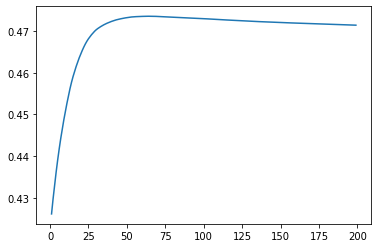

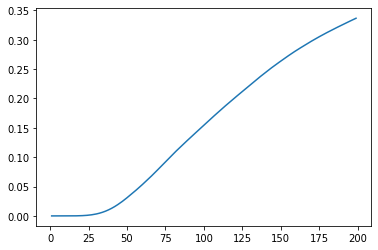

KeyboardInterrupt: 

In [22]:
#penalty with Ncount 
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
test = torch.zeros([1000])
# the function that I'm going to plot
def z_func(x,rloc1,Ncount):
    test = torch.zeros([1000])
    test[rloc1]=x
    Fw=torch.matrix_power(A, int(Ncount))
    meas=Fw@test
    return net1(meas.T.float()).detach().cpu().numpy()




nc = np.arange(1.0,200.0,1.0)
#y = np.arange(0.0,100.0,1.0)
#X,Y = meshgrid(x, y) # grid of point
Z= np.zeros_like(nc)
for j in range(0,1000):
    for n in range (0,199):
        Z[n]=z_func(100,j,nc[n])
    plt.plot(nc,Z)
    plt.pause(0.2)

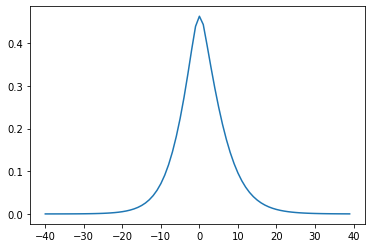

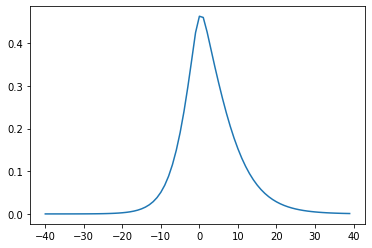

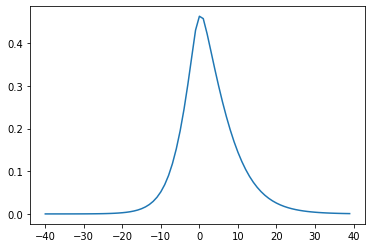

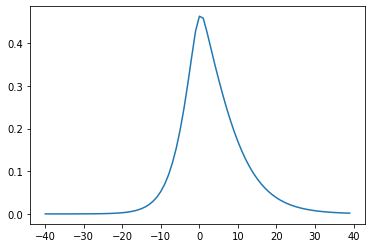

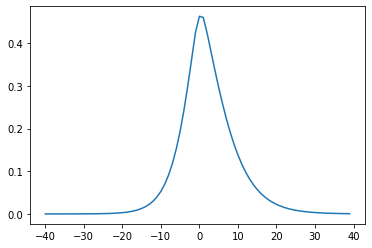

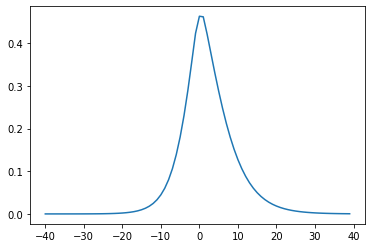

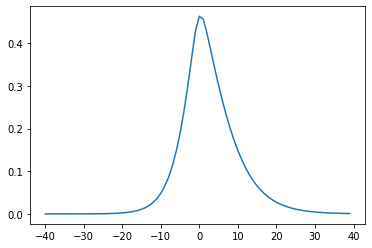

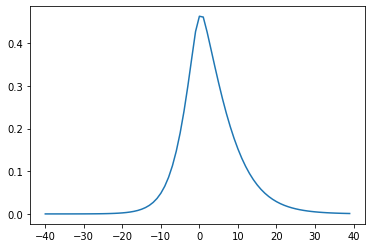

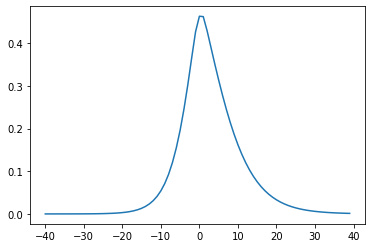

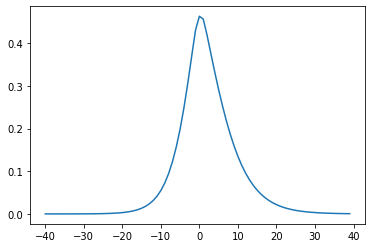

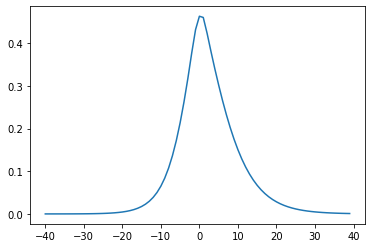

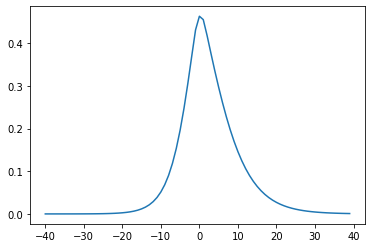

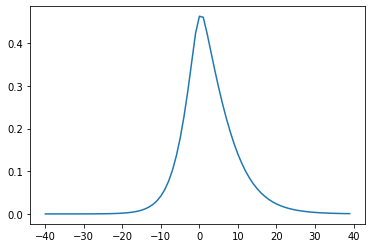

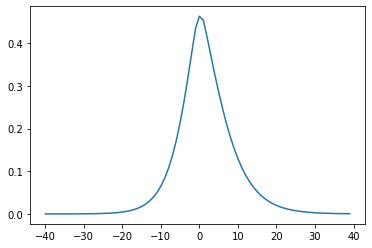

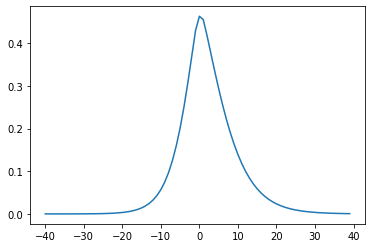

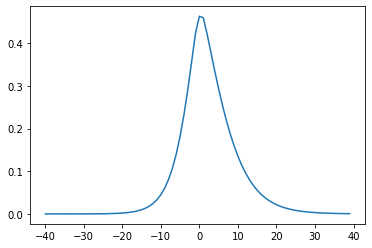

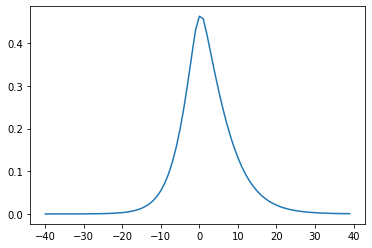

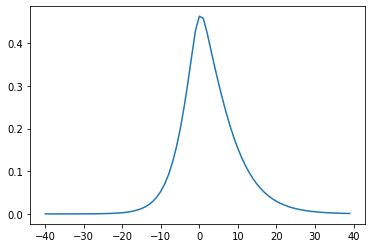

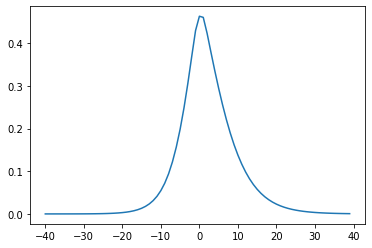

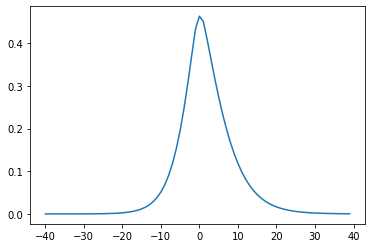

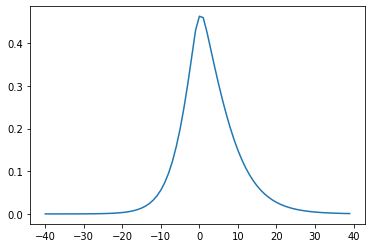

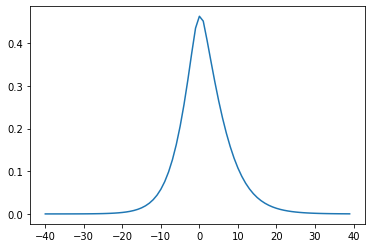

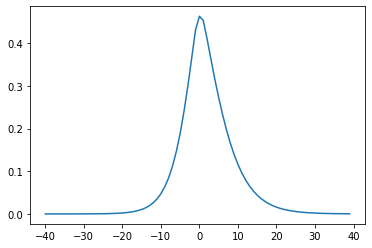

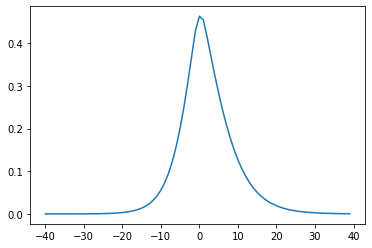

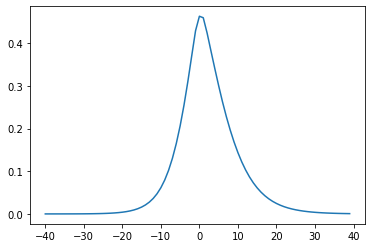

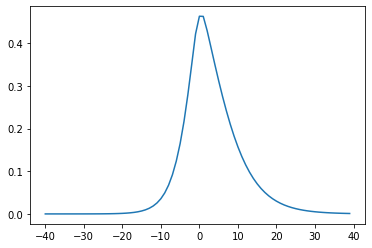

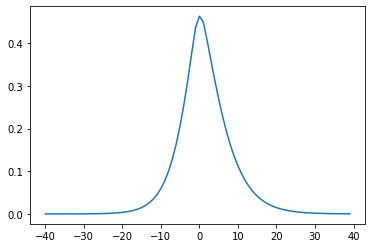

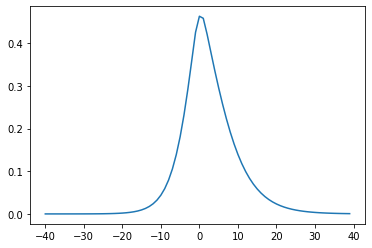

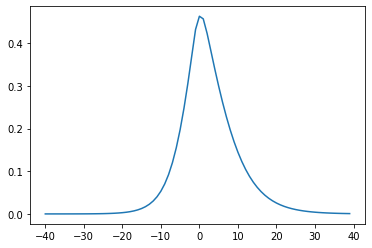

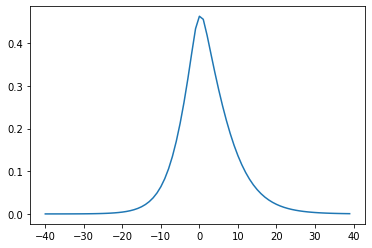

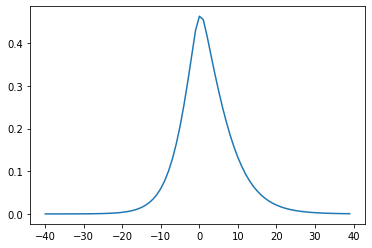

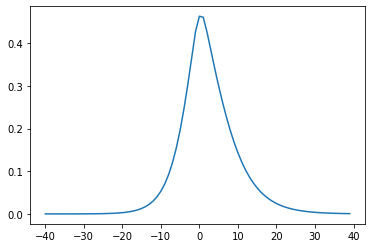

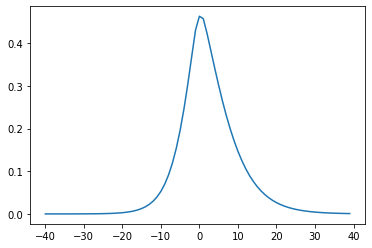

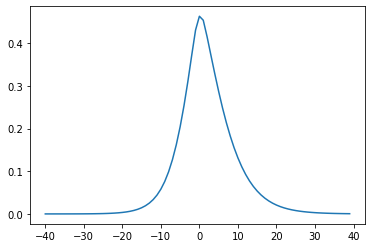

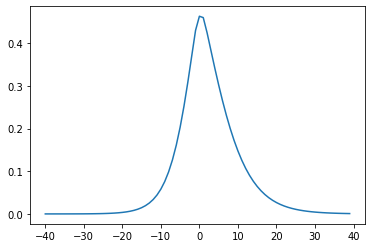

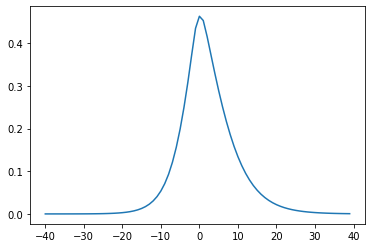

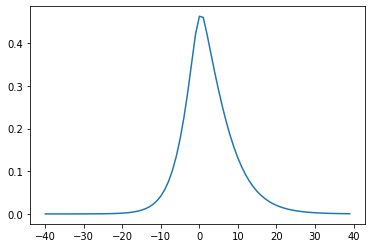

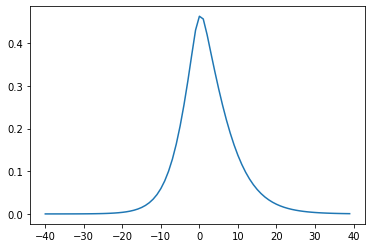

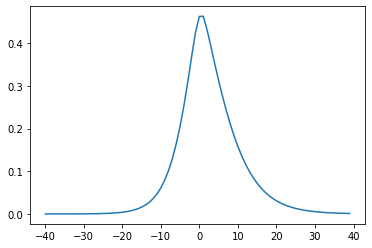

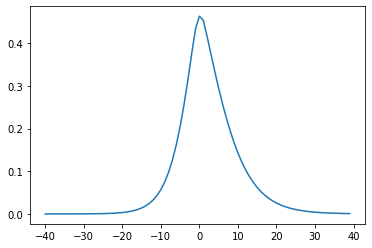

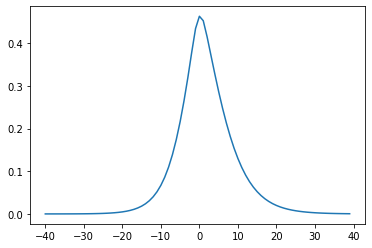

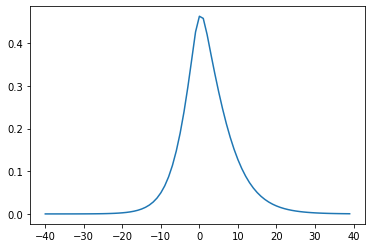

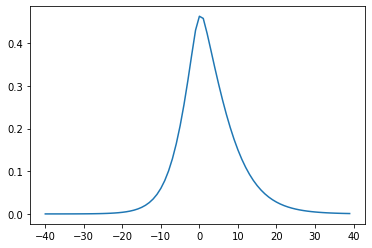

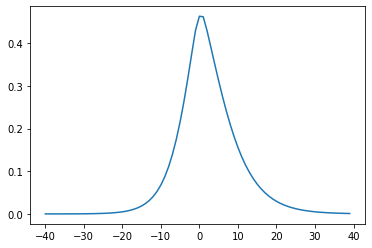

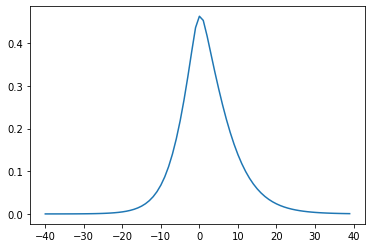

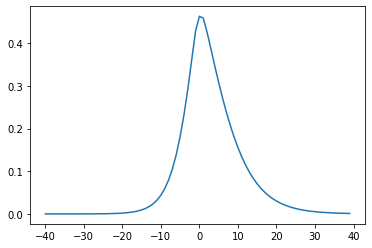

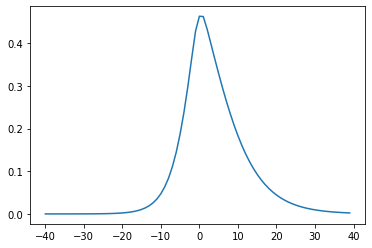

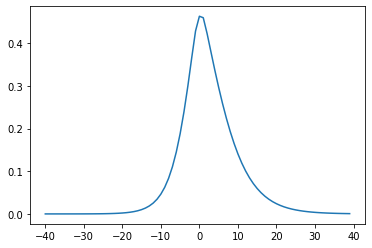

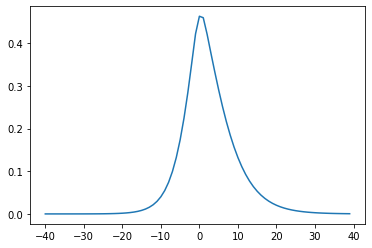

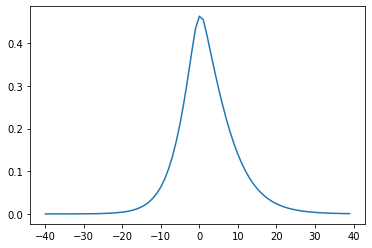

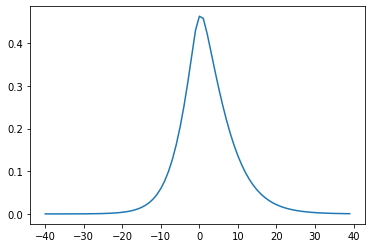

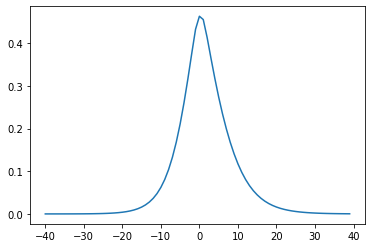

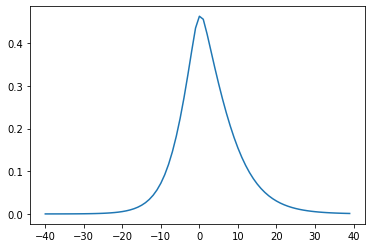

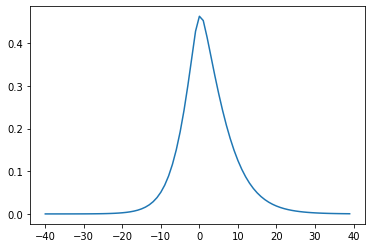

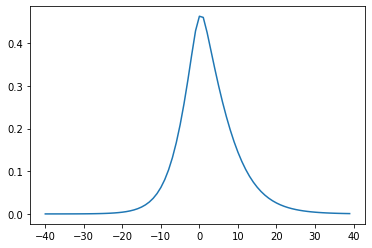

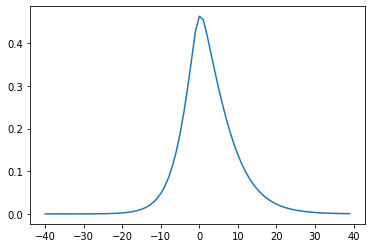

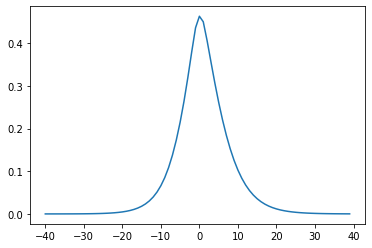

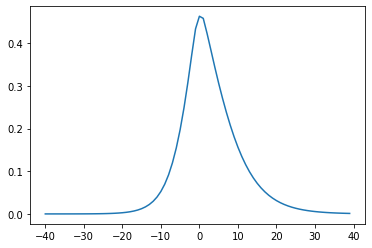

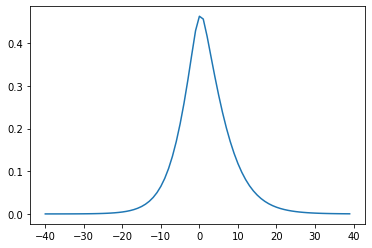

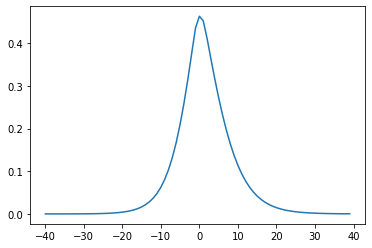

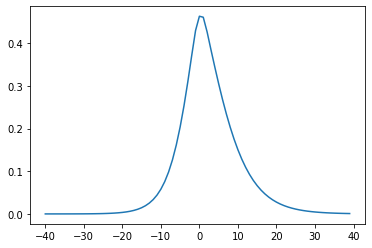

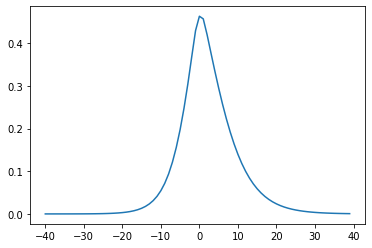

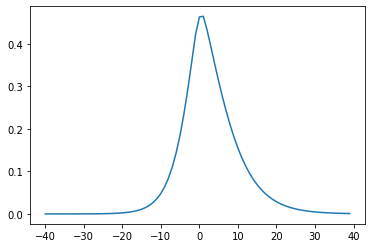

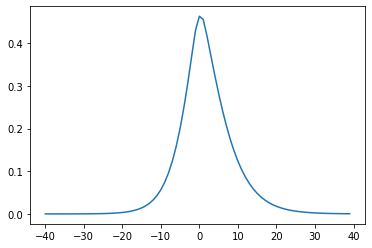

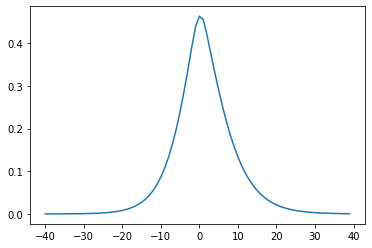

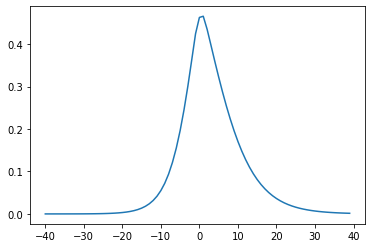

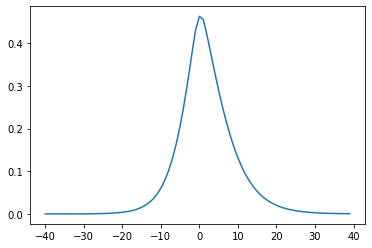

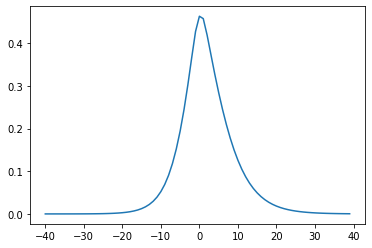

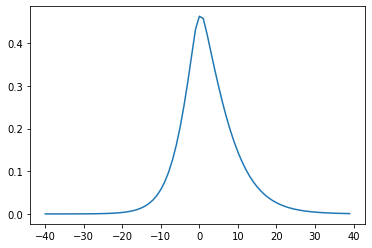

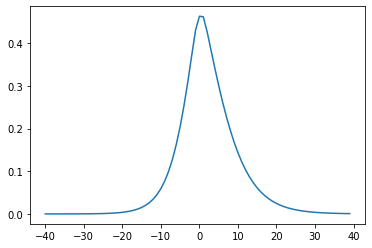

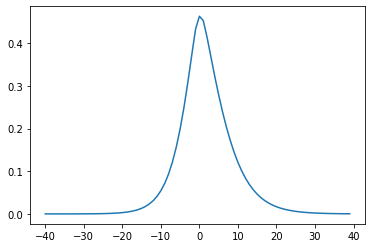

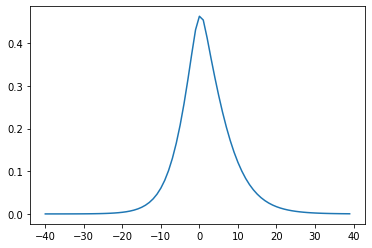

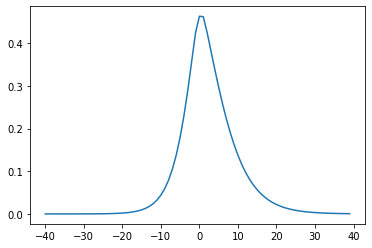

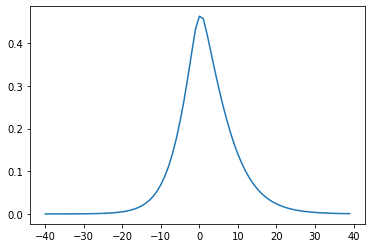

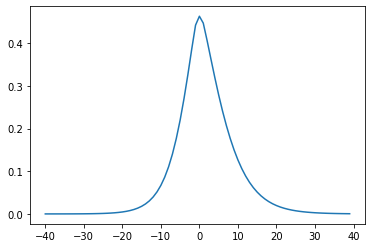

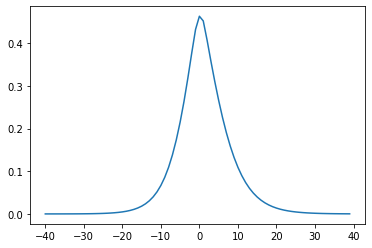

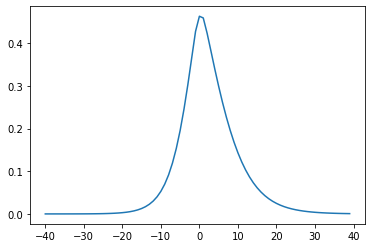

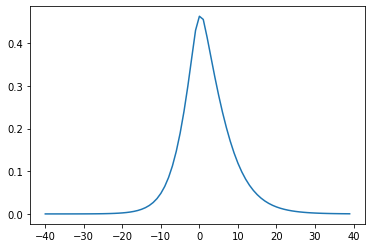

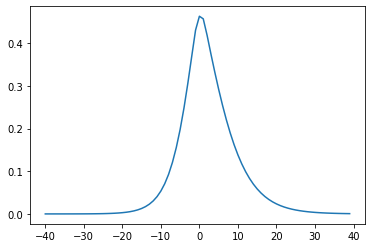

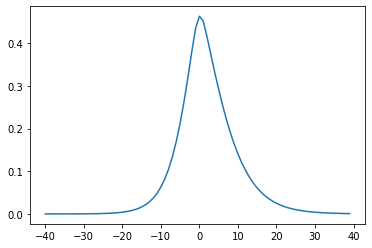

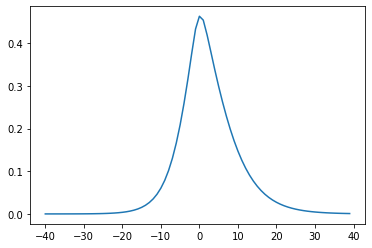

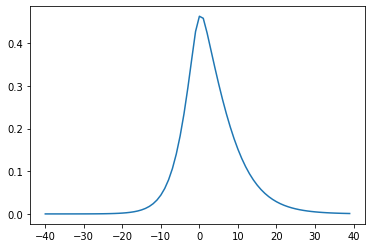

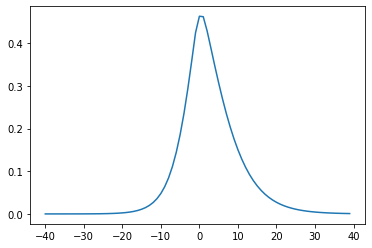

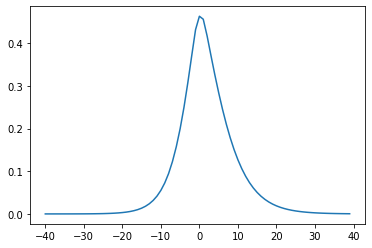

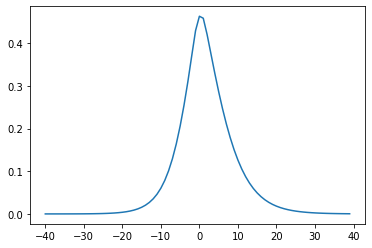

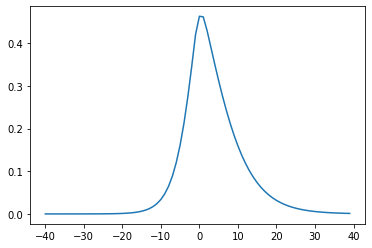

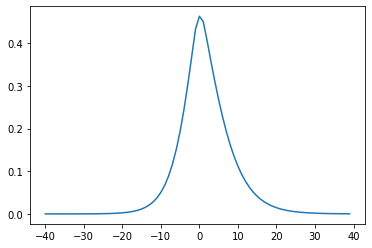

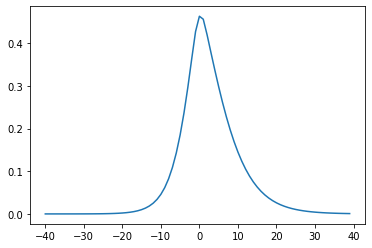

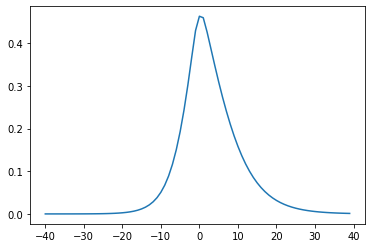

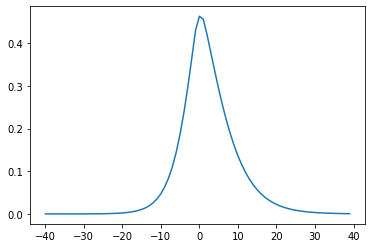

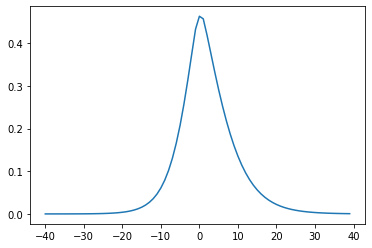

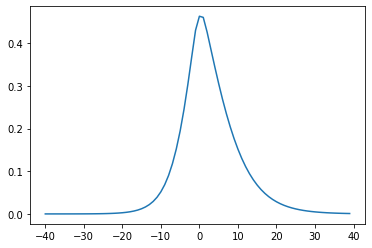

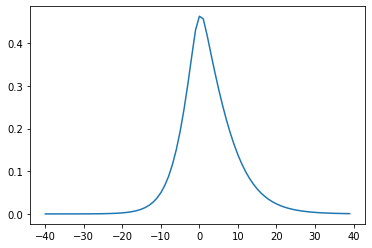

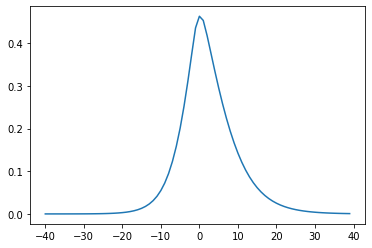

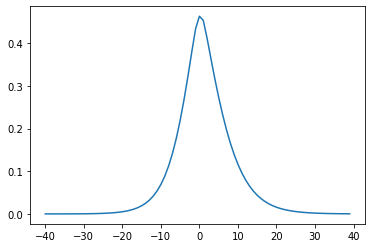

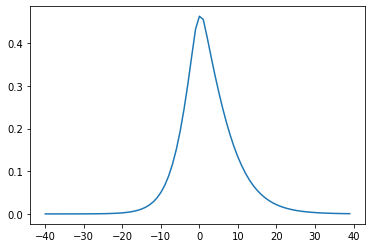

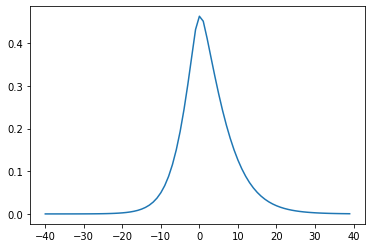

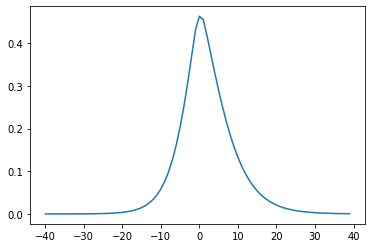

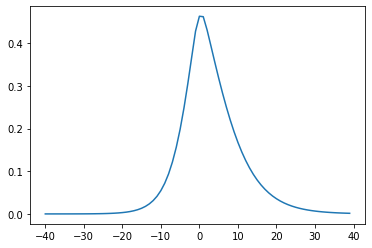

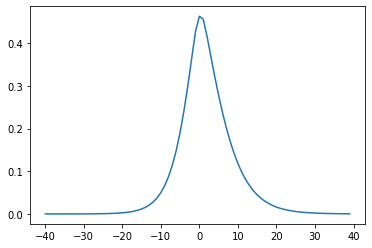

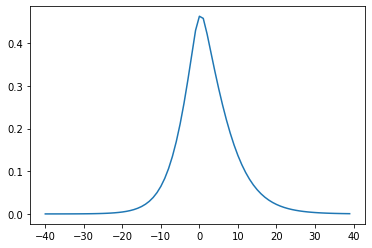

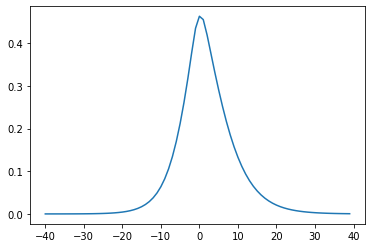

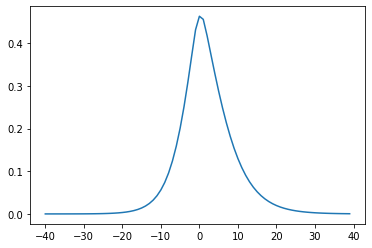

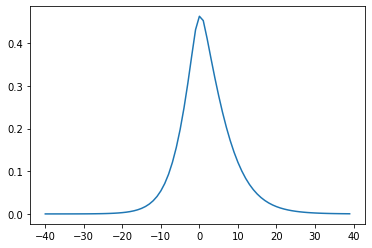

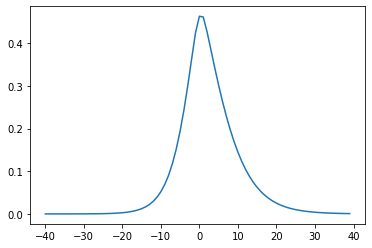

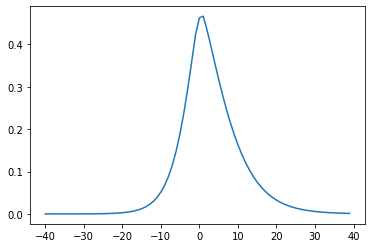

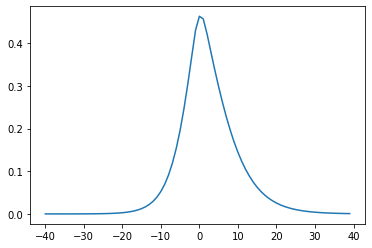

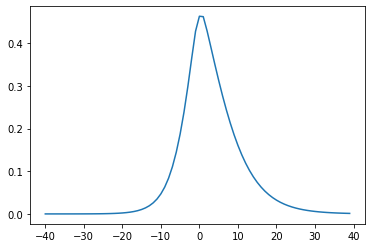

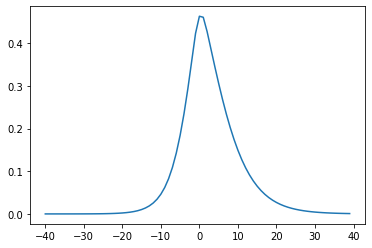

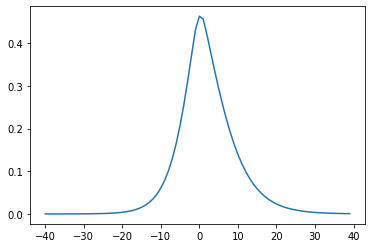

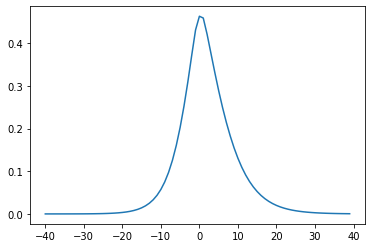

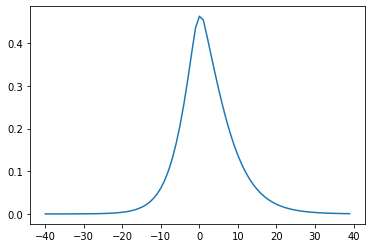

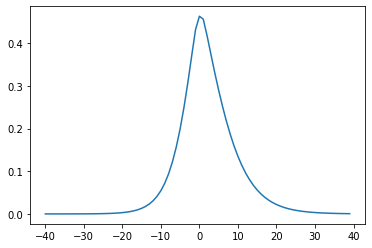

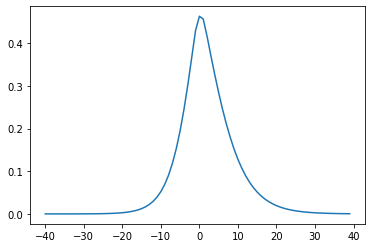

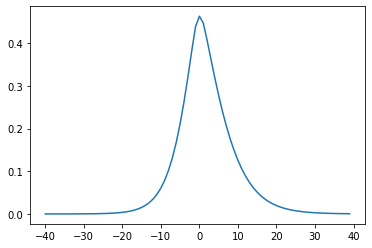

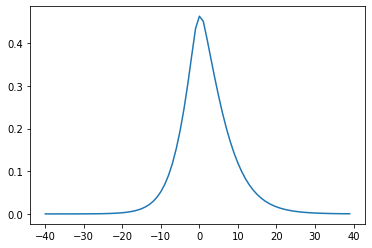

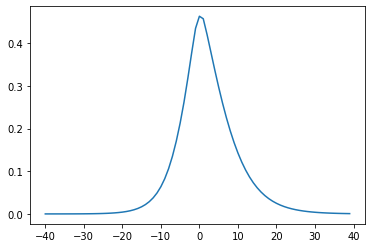

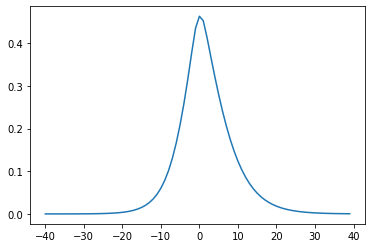

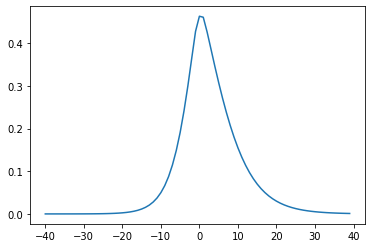

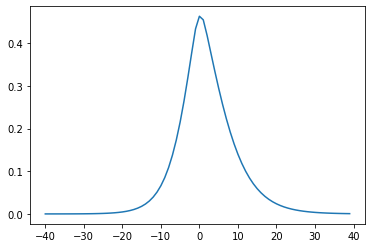

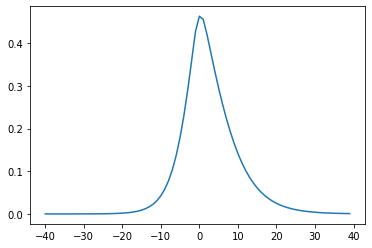

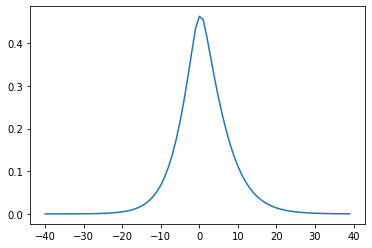

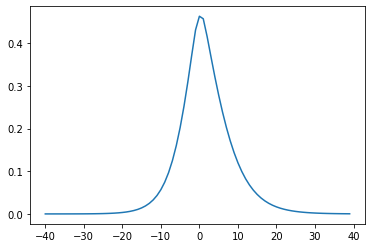

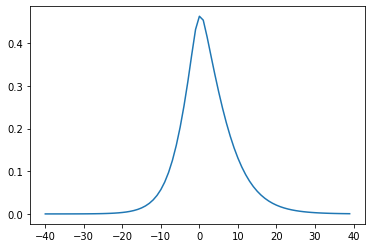

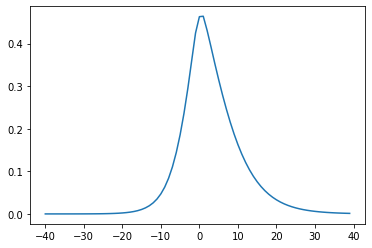

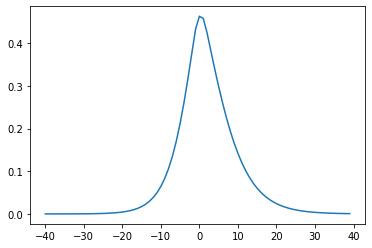

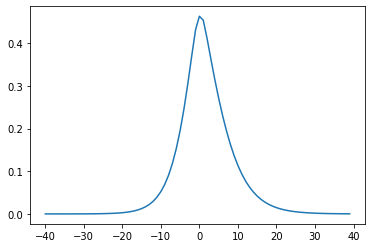

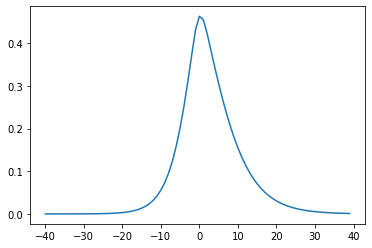

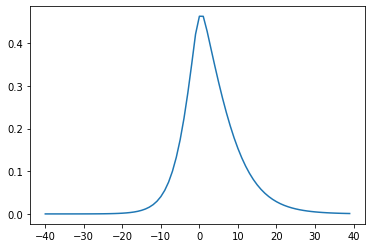

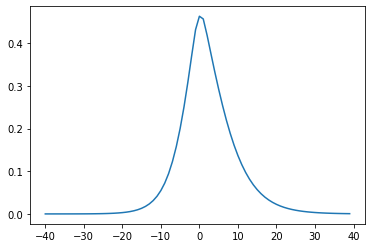

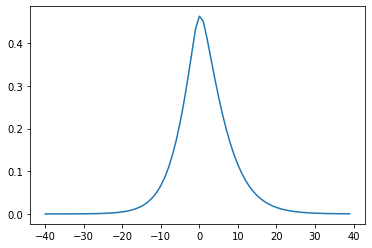

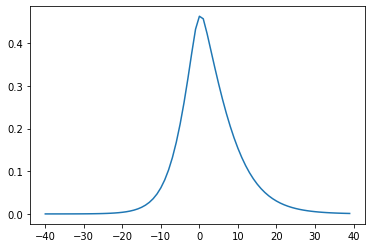

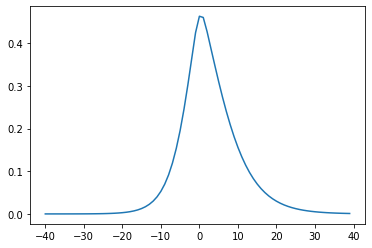

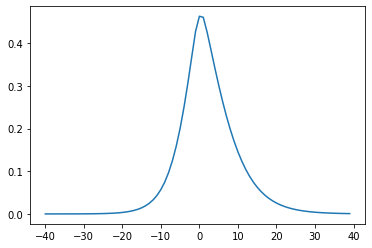

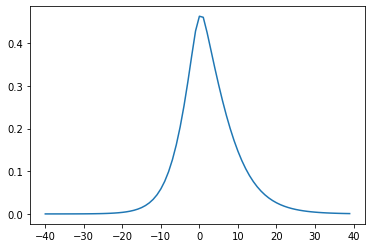

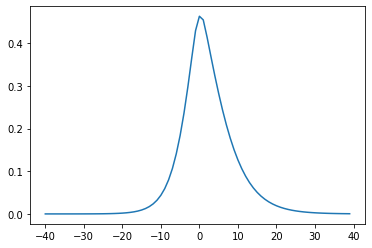

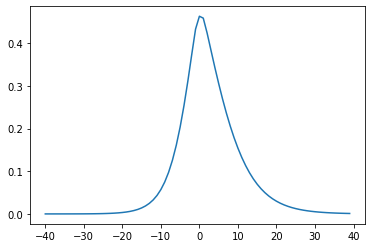

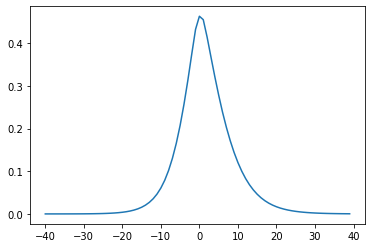

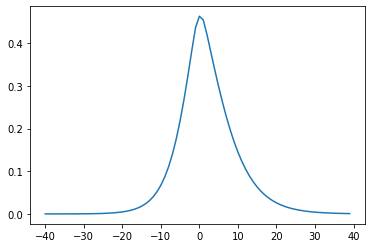

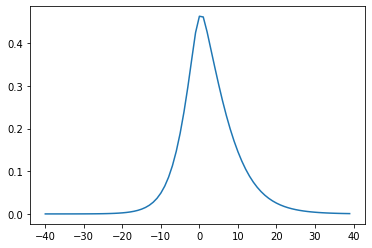

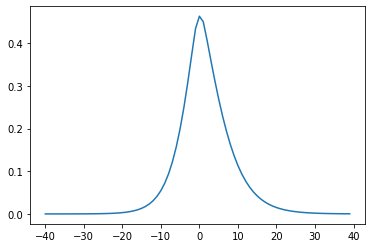

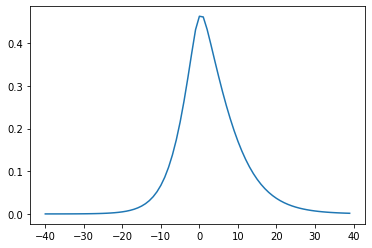

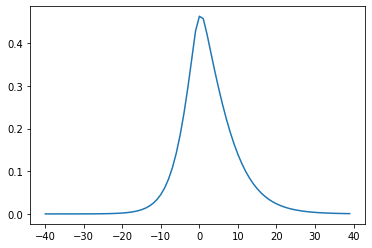

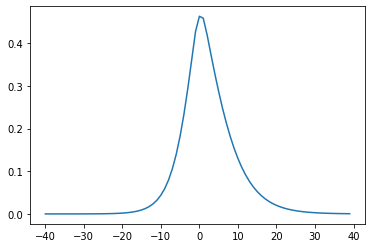

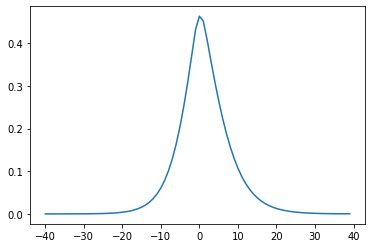

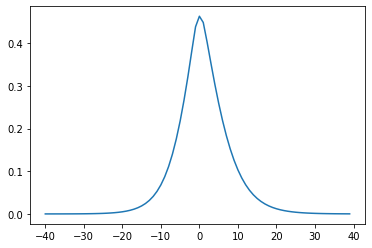

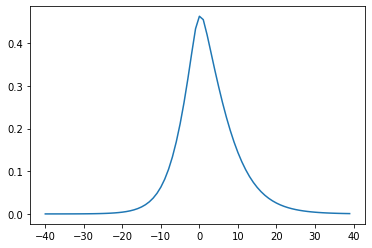

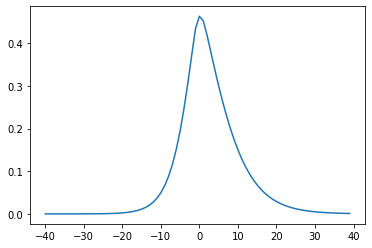

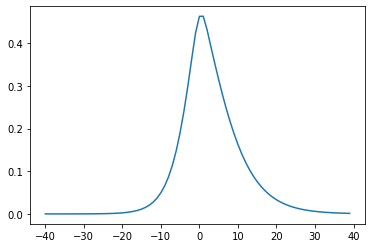

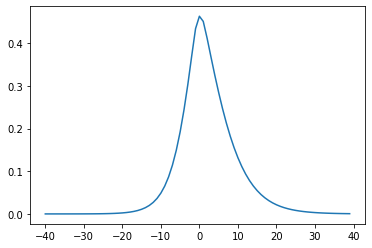

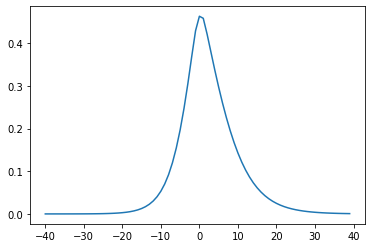

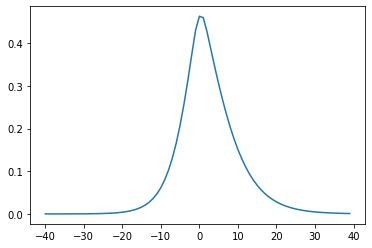

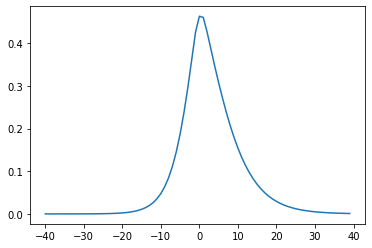

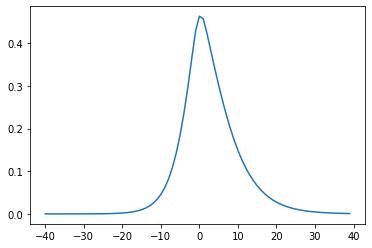

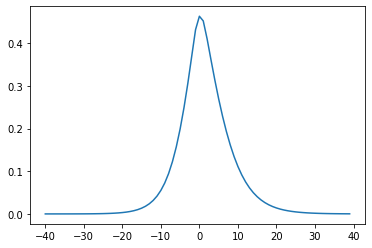

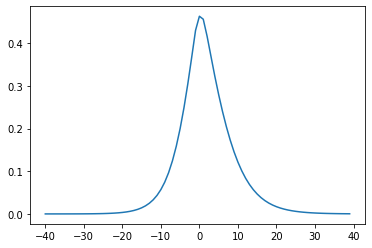

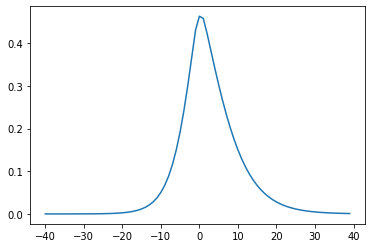

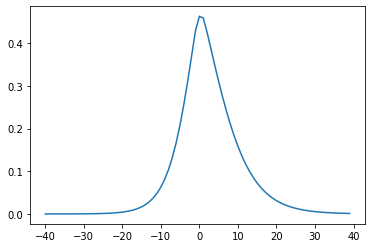

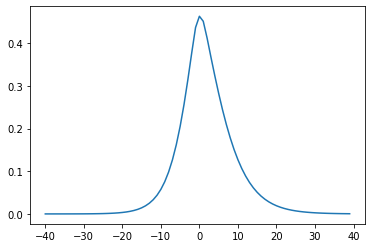

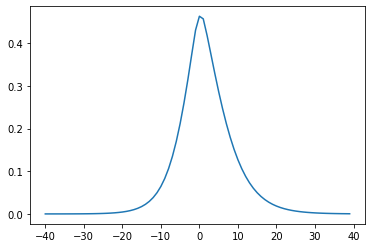

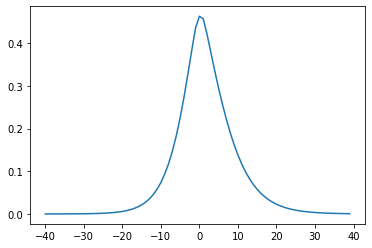

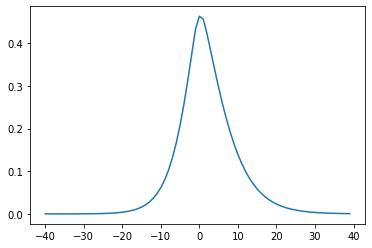

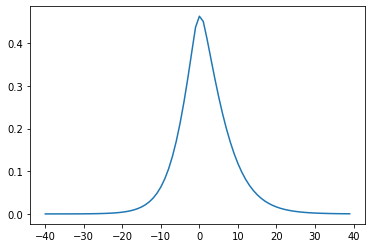

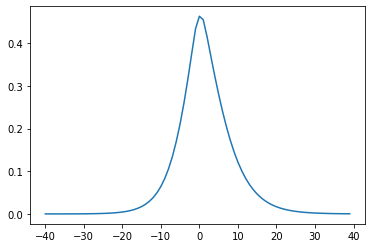

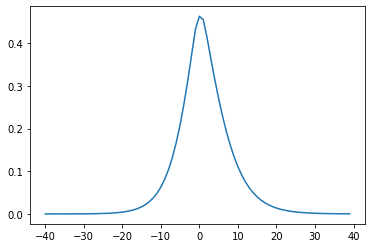

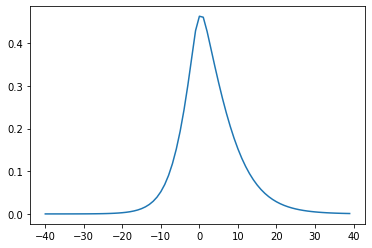

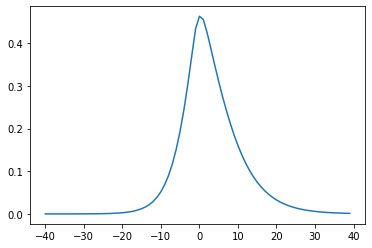

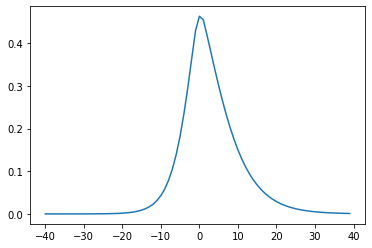

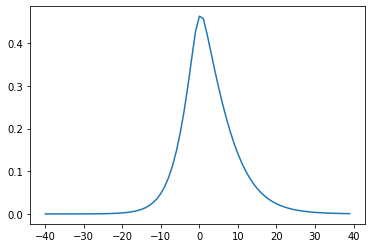

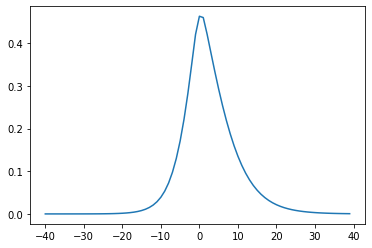

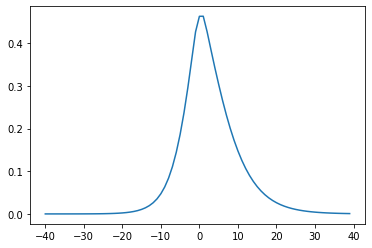

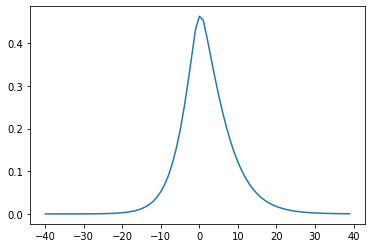

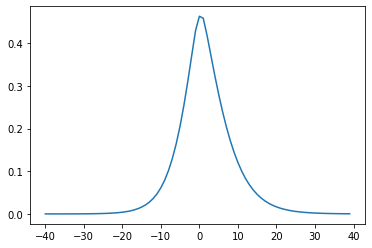

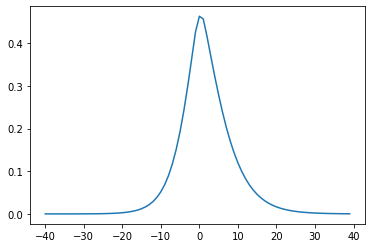

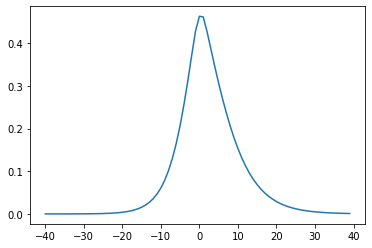

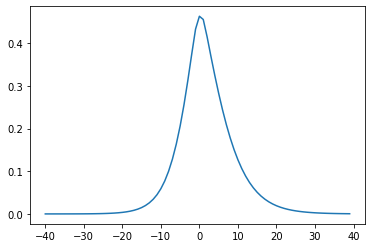

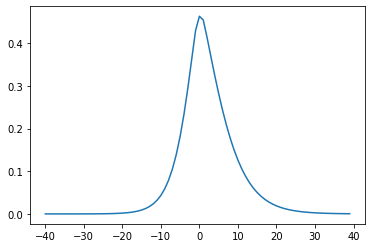

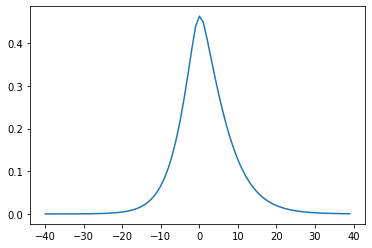

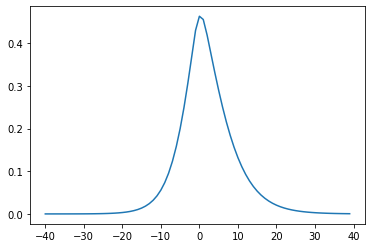

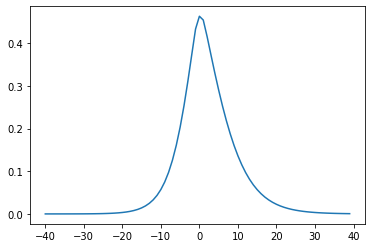

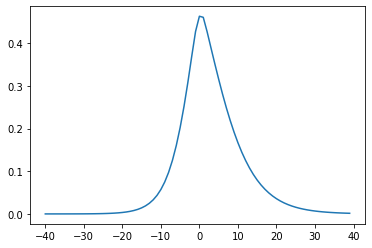

KeyboardInterrupt: 

In [23]:
##penalty variation with amplitude
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
test = torch.zeros([1000])
# the function that I'm going to plot
def z_func(x,rloc1):
    test = torch.zeros([1000])
    test[rloc1]=x
    return net1(test.T.float()).detach().cpu().numpy()
 
x = np.arange(-40.0,40.0,1.0)
#y = np.arange(0.0,100.0,1.0)
#X,Y = meshgrid(x, y) # grid of point
Z= np.zeros_like(x)
for j in range(0,1000):
    for i in range (-40,40):
        Z[i+40]=z_func(x[i+40],j)
    plt.plot(x,Z)
    plt.pause(0.2)

In [51]:
#main problem 
import numpy as np
import torch 
from numpy.linalg import matrix_power
N=1000
alpha=25
s=1/(2*alpha)
A=torch.zeros((N,N))

for i in range(0,N-1):
    A[i,i]=1-2*s
    A[i,i-1]=s
    A[i,i+1]=s

#A[:,0]=0
#A[:,N-1]=0
A[0,:]=0
A[N-1,:]=0
u=torch.zeros((N,1))
u[150]=1000
u[500]=1000
u[750]=1000

Ncount=1000
Fw=torch.matrix_power(A, Ncount)
meas=Fw@u

133986.78125


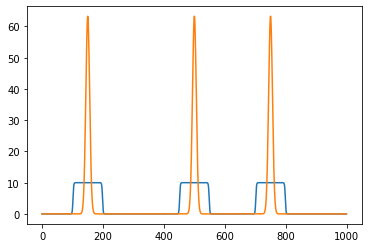

tensor(190.)
101898.1953125


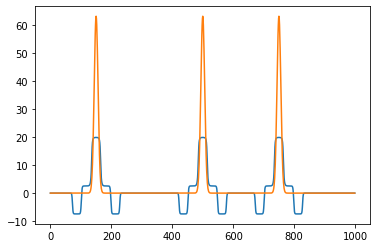

tensor(180.)
59987.234375


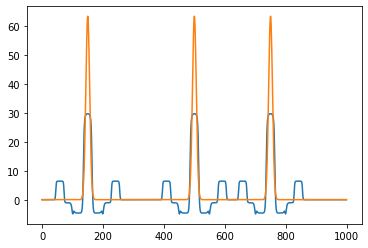

tensor(170.)
37553.01171875


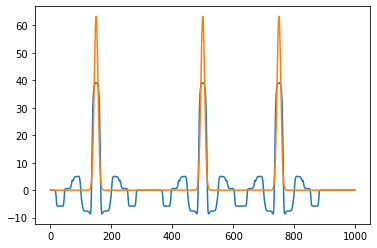

tensor(180.)
31816.146484375


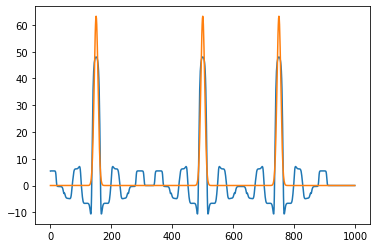

tensor(190.)
27311.80078125


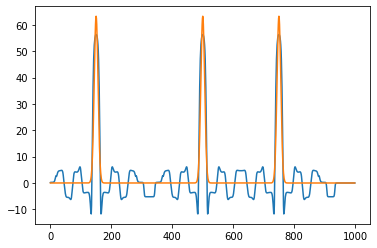

tensor(200.)
21343.09765625


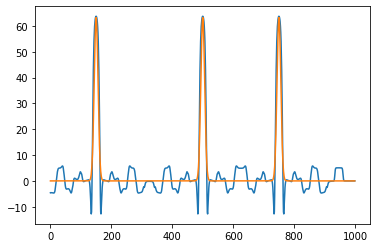

tensor(210.)
16419.0859375


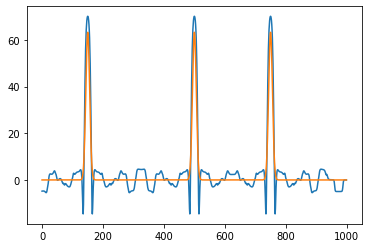

tensor(220.)
17234.486328125


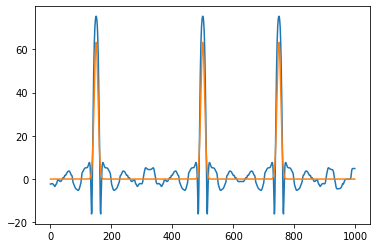

tensor(230.)
21394.859375


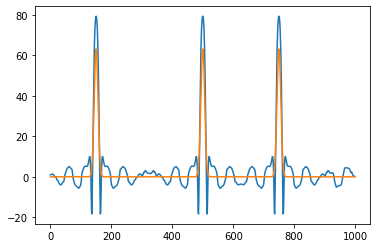

tensor(240.)
24245.8203125


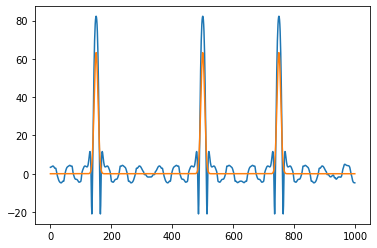

tensor(250.)
22119.76171875


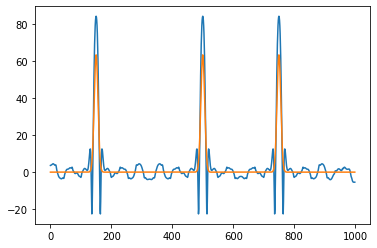

tensor(260.)
16834.68359375


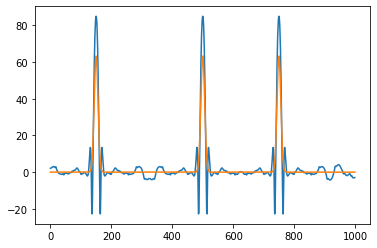

tensor(270.)
12728.939453125


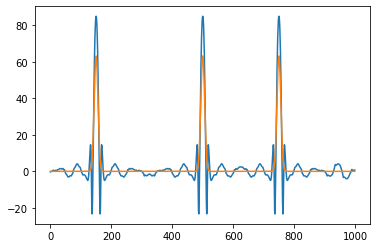

tensor(280.)
12094.783203125


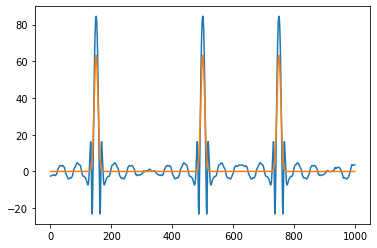

tensor(290.)
12765.5947265625


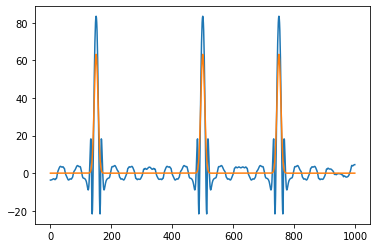

tensor(300.)
11362.57421875


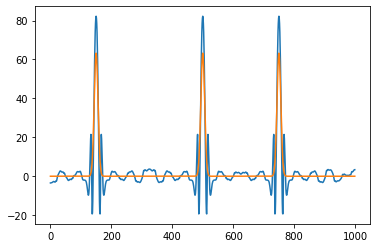

tensor(310.)
7666.1484375


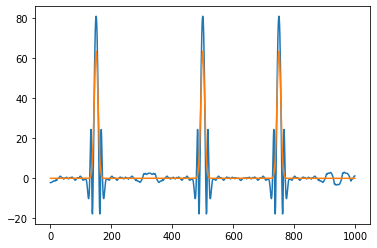

tensor(320.)
4512.73876953125


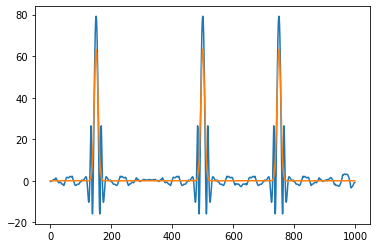

tensor(330.)
4077.76513671875


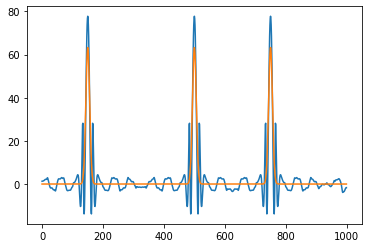

tensor(340.)
5384.76416015625


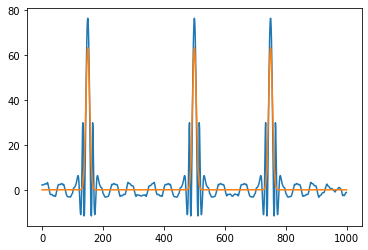

tensor(350.)
5938.08984375


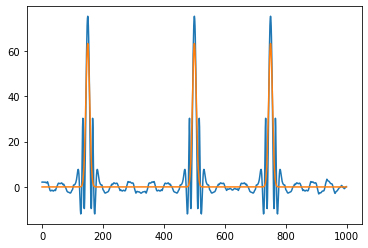

tensor(360.)
4900.806640625


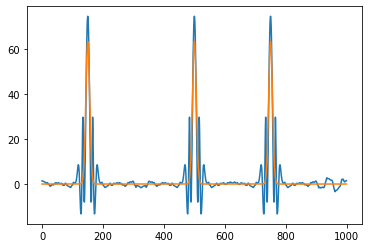

tensor(350.)
3698.090576171875


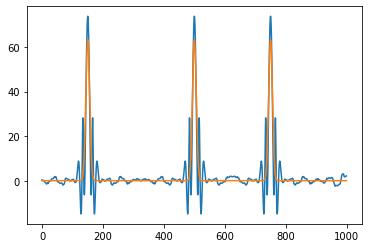

tensor(340.)
3446.566162109375


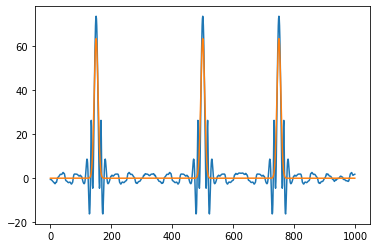

tensor(330.)
3956.2626953125


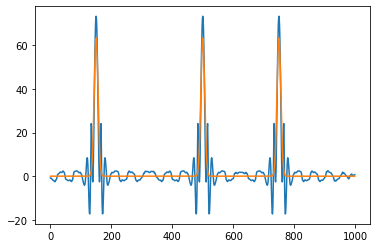

tensor(320.)
4096.22216796875


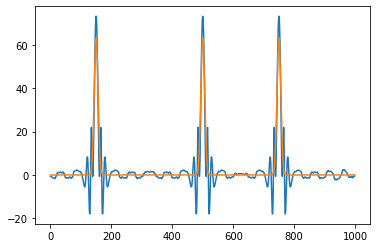

tensor(310.)
3433.697998046875


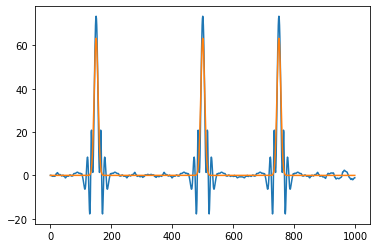

tensor(300.)
2583.254638671875


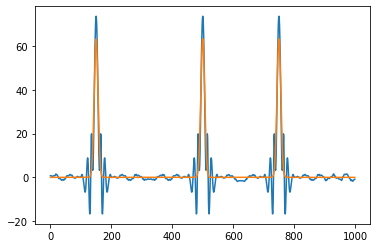

tensor(310.)
2064.880126953125


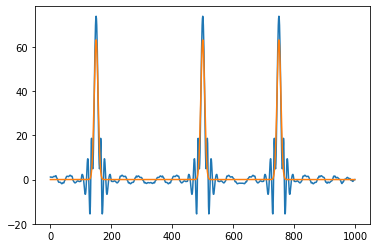

tensor(320.)
2016.24951171875


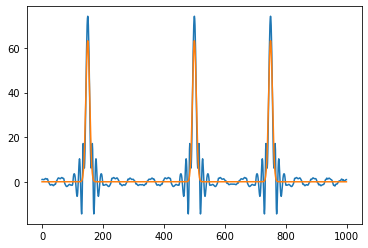

tensor(330.)
1930.997802734375


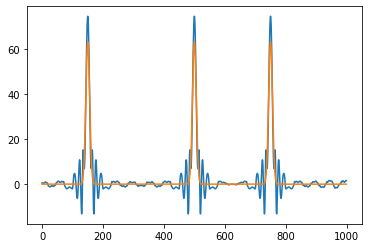

tensor(340.)
1601.632568359375


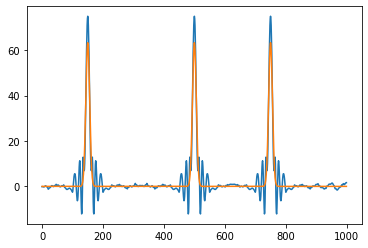

tensor(350.)
1258.8240966796875


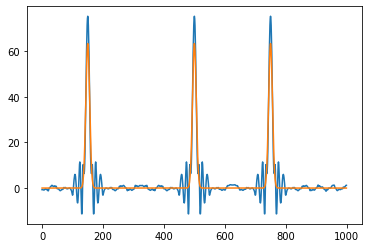

tensor(360.)
1143.522705078125


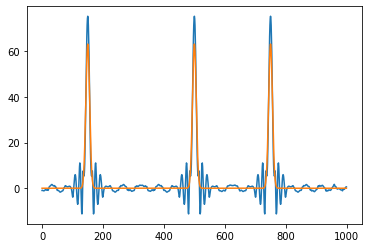

tensor(370.)
1178.2783203125


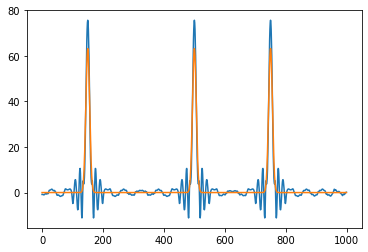

tensor(380.)
1127.1041259765625


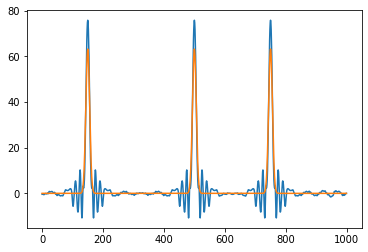

tensor(390.)
943.6378173828125


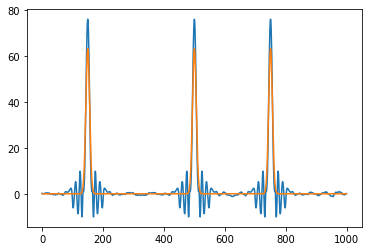

tensor(400.)
795.52294921875


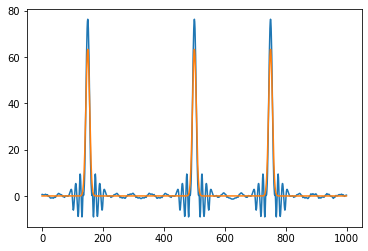

tensor(410.)
773.6559448242188


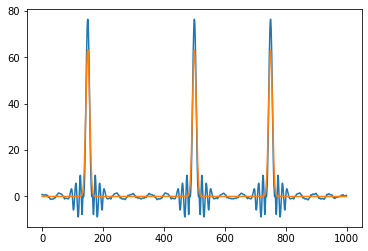

tensor(420.)
761.2199096679688


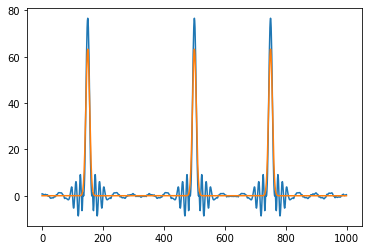

tensor(430.)
649.5286865234375


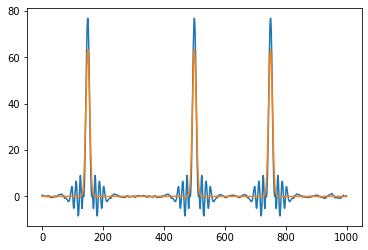

tensor(440.)
520.5451049804688


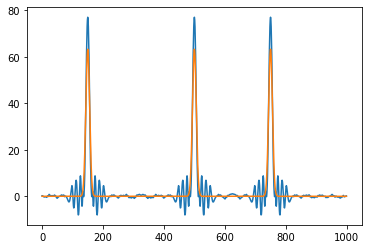

tensor(450.)
496.26531982421875


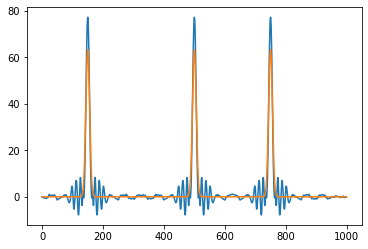

tensor(460.)
529.5794067382812


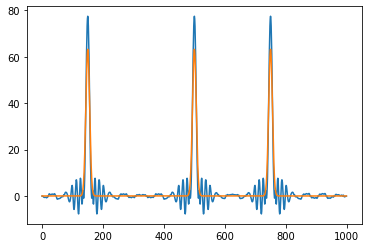

tensor(450.)
481.26971435546875


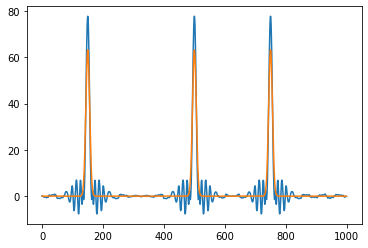

tensor(460.)
372.4266662597656


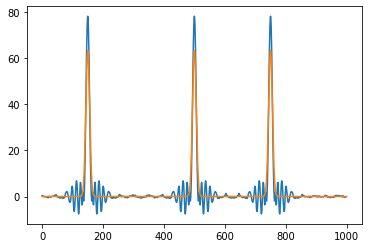

tensor(450.)
321.5246276855469


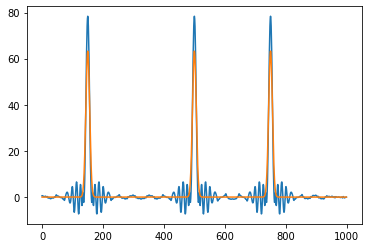

tensor(460.)
337.0784606933594


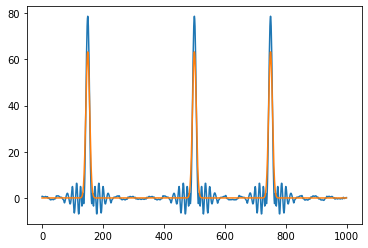

tensor(470.)
335.73675537109375


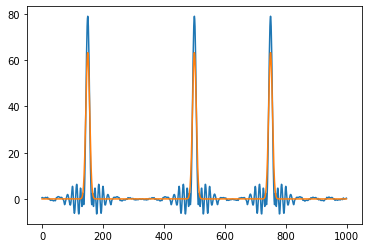

tensor(460.)
282.16107177734375


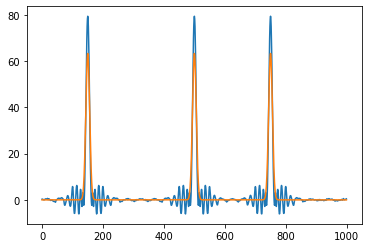

tensor(470.)
211.9694061279297


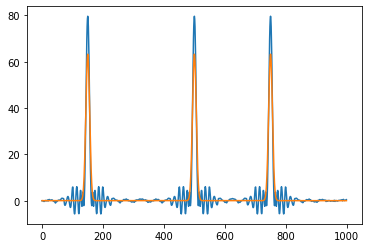

tensor(480.)
202.2875213623047


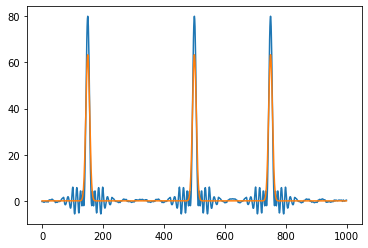

tensor(490.)
216.16116333007812


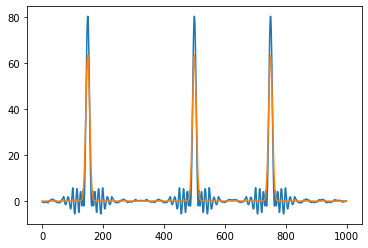

tensor(500.)
201.2616424560547


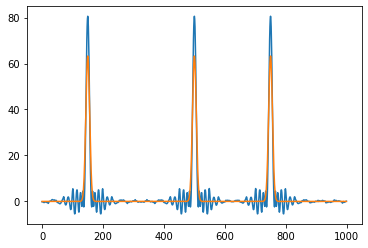

tensor(490.)
150.0178680419922


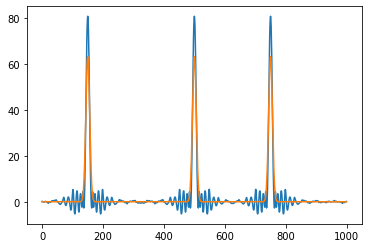

tensor(500.)
133.96160888671875


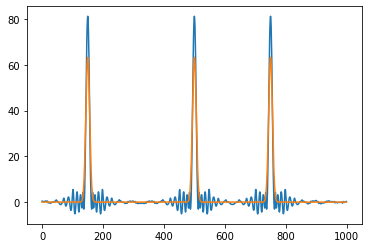

tensor(490.)
134.11325073242188


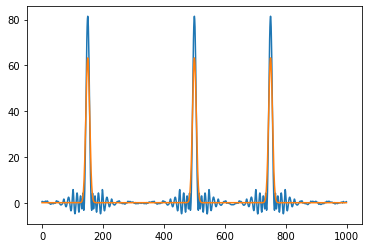

tensor(500.)
126.55695343017578


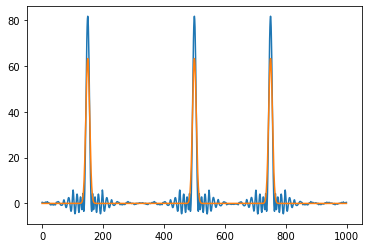

tensor(510.)
106.64370727539062


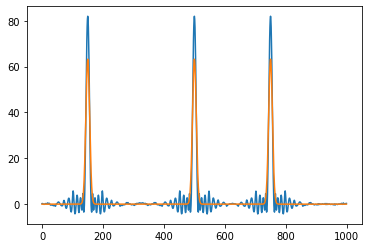

tensor(500.)
92.62577819824219


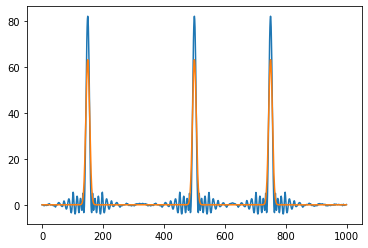

tensor(510.)
85.65049743652344


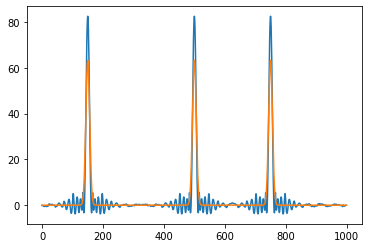

tensor(520.)
86.90342712402344


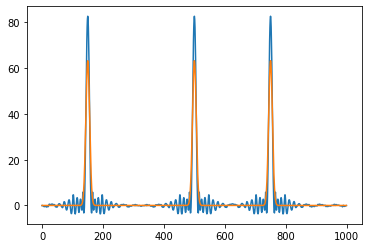

tensor(530.)
85.17618560791016


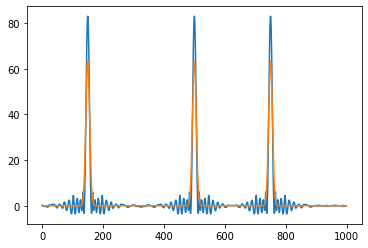

tensor(520.)
63.68096923828125


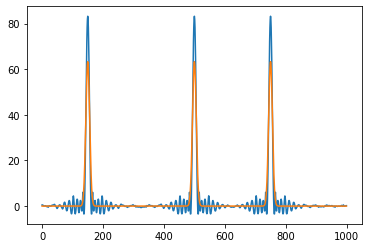

tensor(530.)
59.94539260864258


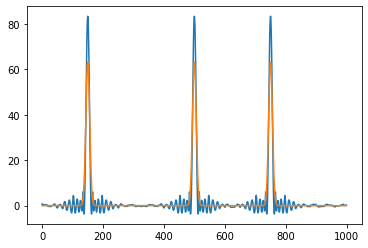

tensor(520.)
54.28549575805664


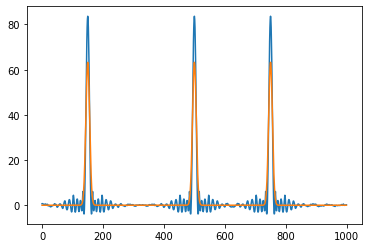

tensor(530.)
52.704917907714844


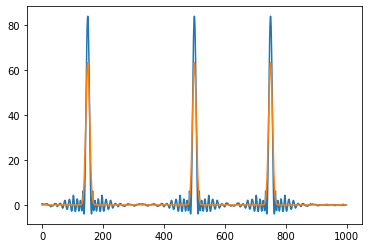

tensor(540.)
50.24203872680664


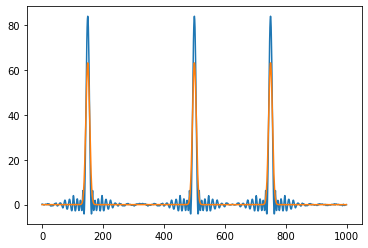

tensor(530.)
41.839962005615234


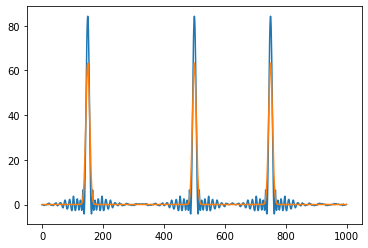

tensor(540.)
37.38663101196289


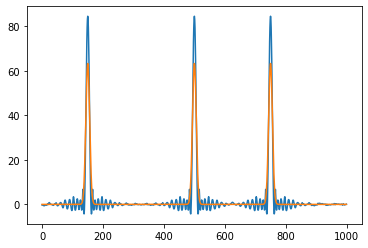

tensor(530.)
34.37059783935547


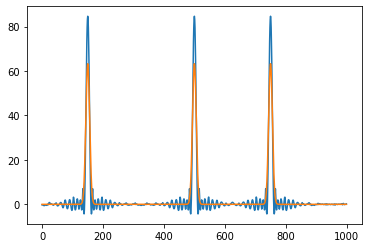

tensor(540.)
33.84735870361328


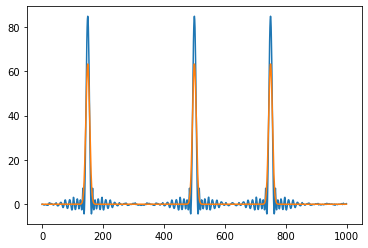

tensor(550.)
35.995513916015625


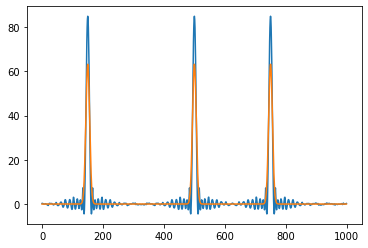

tensor(540.)
26.623624801635742


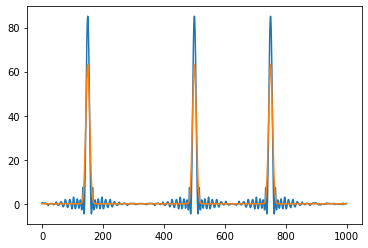

tensor(550.)
25.20594024658203


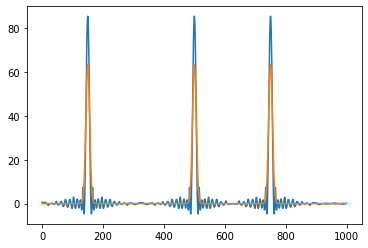

tensor(540.)
23.21650505065918


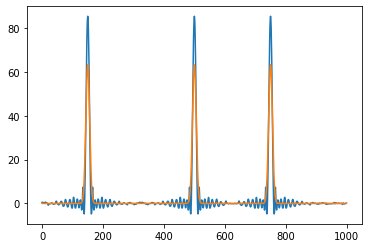

tensor(550.)
22.938243865966797


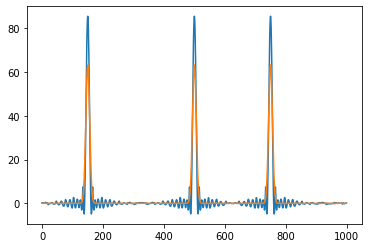

tensor(560.)
24.132349014282227


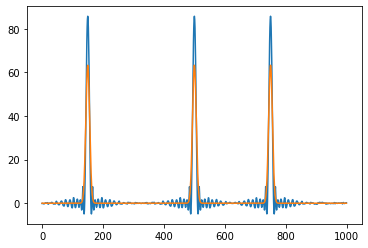

tensor(550.)
17.656465530395508


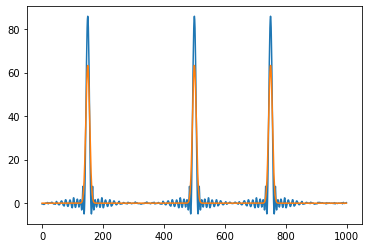

tensor(560.)
17.975290298461914


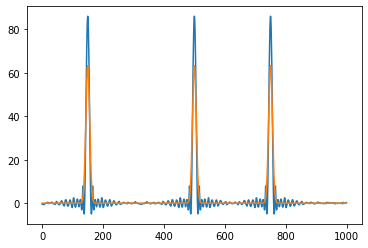

tensor(550.)
16.123647689819336


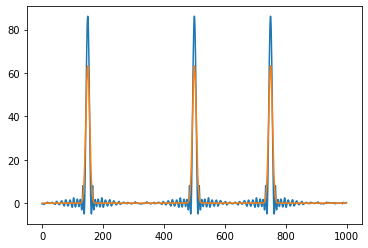

tensor(560.)
17.30801773071289


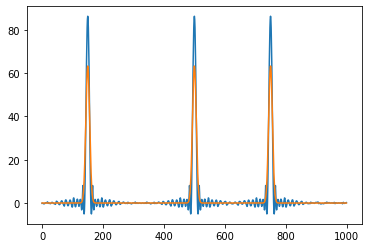

tensor(570.)
20.05379295349121


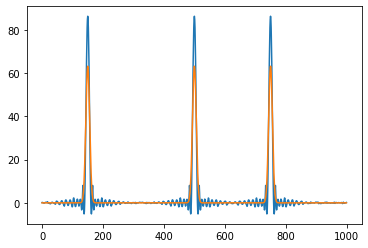

tensor(560.)
11.979900360107422


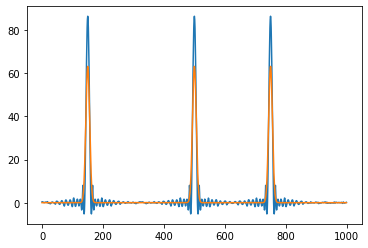

tensor(570.)
15.228996276855469


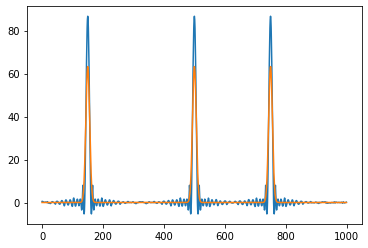

tensor(560.)
13.377037048339844


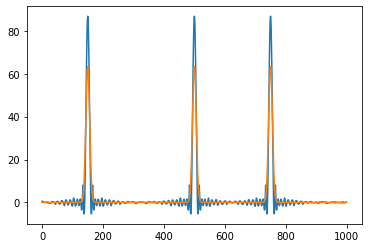

tensor(570.)
13.03095817565918


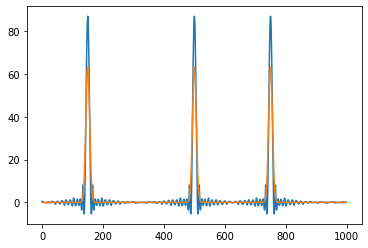

tensor(560.)
11.003764152526855


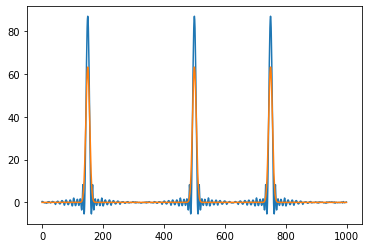

tensor(570.)
10.199581146240234


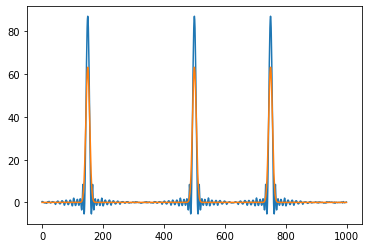

tensor(580.)
14.97696590423584


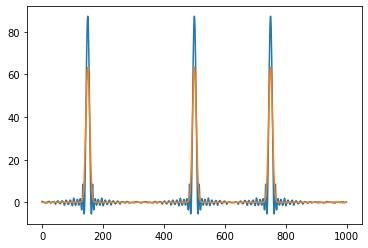

tensor(570.)
9.64107894897461


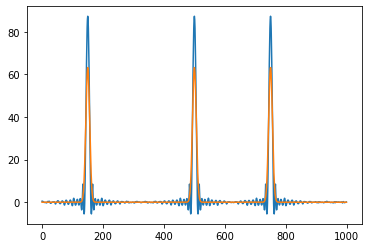

tensor(580.)
11.65978717803955


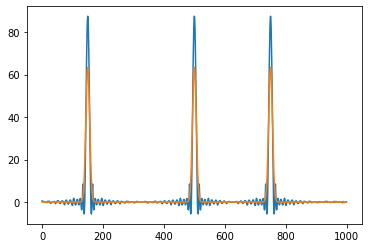

tensor(570.)
7.983844757080078


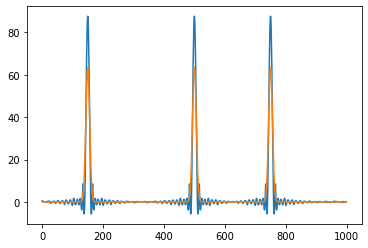

tensor(580.)
9.346627235412598


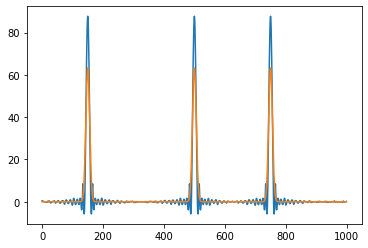

tensor(570.)
8.626412391662598


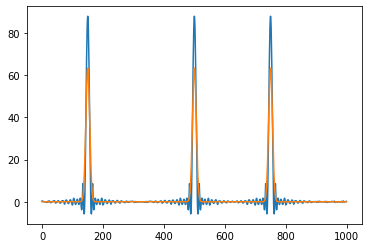

tensor(580.)
7.987812519073486


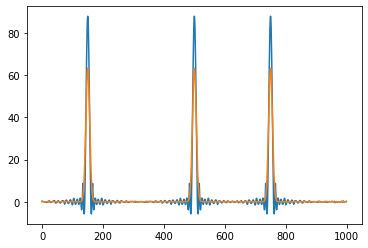

tensor(590.)
11.872712135314941


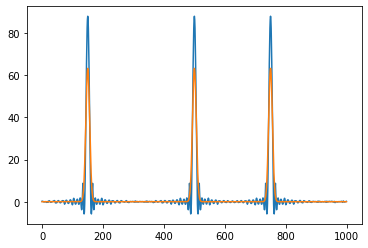

tensor(580.)
6.885942459106445


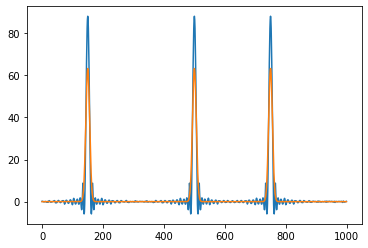

tensor(590.)
10.141162872314453


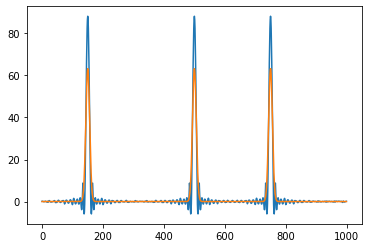

tensor(580.)


In [56]:
##Performance of l2-l1-nonnegative constraint
import matplotlib.pylab as plt
x1 = torch.zeros((1000,1))  # initial value of x
x1.requires_grad_(True)  # turn on gradients w.r.t. x
optimizer = torch.optim.Adam([x1], lr=1e1)
beta=5000
beta1 = 25
beta3 = 25
Ncount=200
for iter in range(100):  # for N iterations...
    with torch.no_grad():
        Fw = torch.matrix_power(A, int(Ncount))
            
        
    optimizer.zero_grad()  # zero the gradients 
    loss = torch.sum((Fw.matmul(x1) - meas)**2) #+ beta3*torch.sum(torch.abs(x1)) #+ beta1*torch.norm(x1[x1<0])#+ beta*net1(x1.T) +beta1*torch.norm(x1[x1<0])#+ beta*net1(x1.T)#  # compute the loss
        #loss = torch.sum((Fw.matmul(x1) - meas)**2) + beta*net1(x1.T) +beta1*torch.norm(x1[x1<0]) + beta3*torch.norm(x1,2) #+ beta*net1(x1.T)
    loss.backward()  # take gradients of the loss
    optimizer.step()  # take a gradient step (changes x!)       
    print(loss.item())    
    plt.plot(x1.detach().numpy())
    plt.plot(meas)
    plt.pause(0.2)
    t = l2min_grad(meas,x1.detach().numpy(),A,t0=Ncount,step =1e1,iters=1)
    Ncount=t

134218.3125


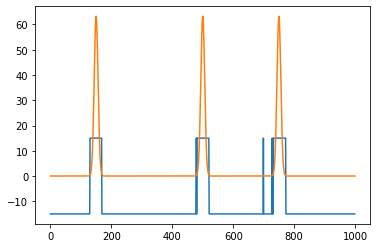

471805.9375


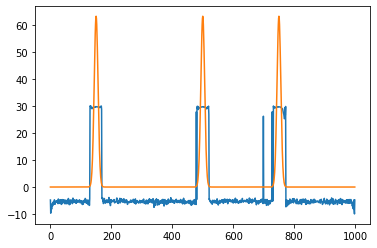

146181.5625


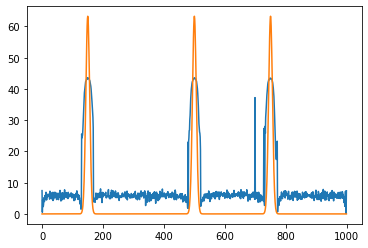

75015.25


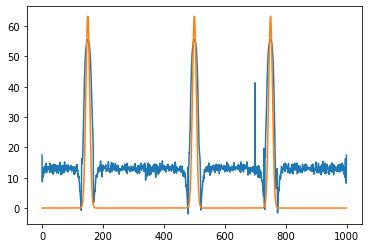

179147.46875


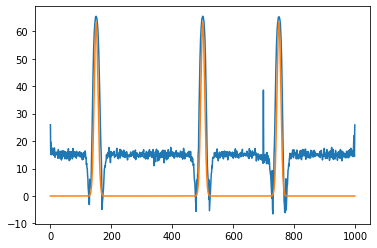

219258.21875


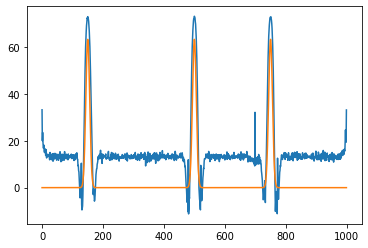

177890.65625


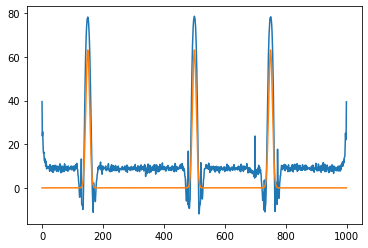

104610.75


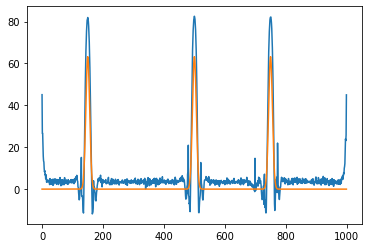

48846.30859375


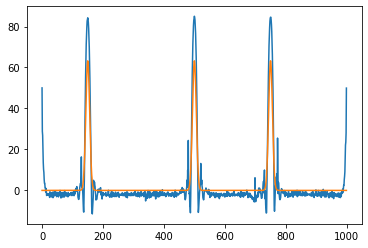

49973.078125


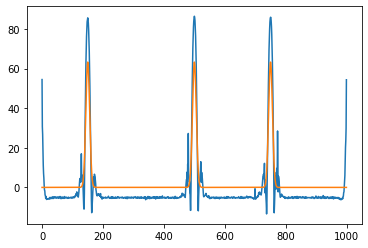

101871.3203125


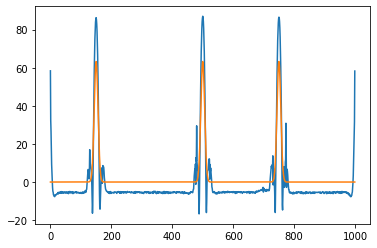

110518.4375


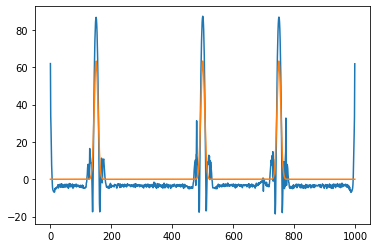

74971.125


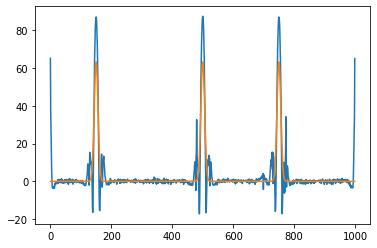

38698.125


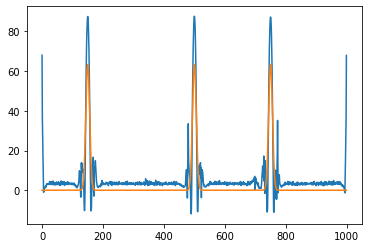

37240.9765625


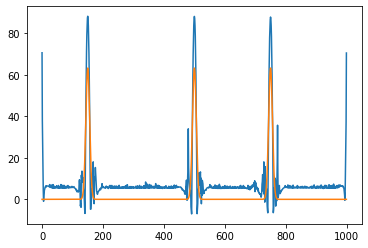

45783.1328125


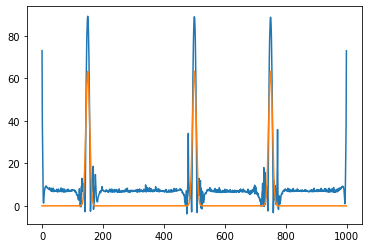

51807.53515625


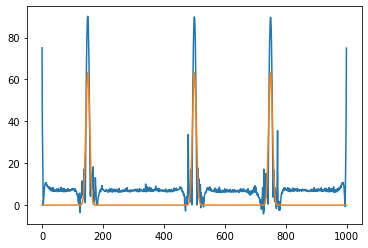

51685.796875


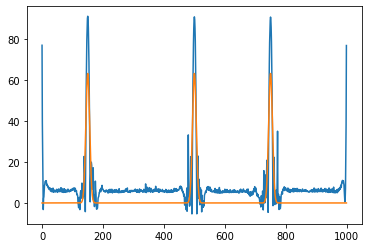

44228.87890625


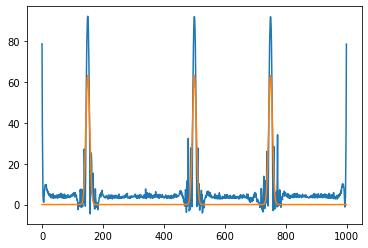

28506.7421875


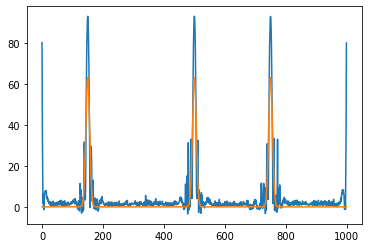

17378.234375


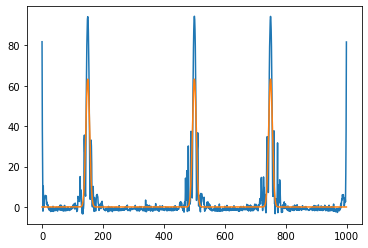

28111.17578125


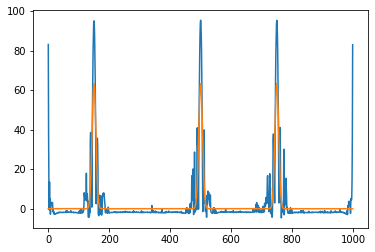

38354.234375


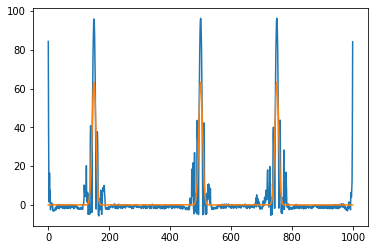

31035.251953125


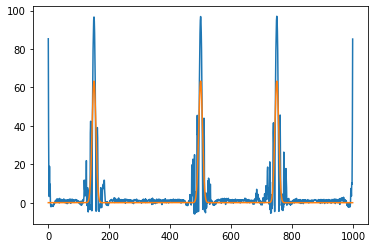

24133.03515625


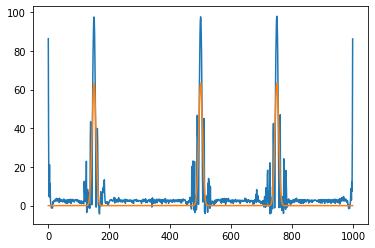

23578.724609375


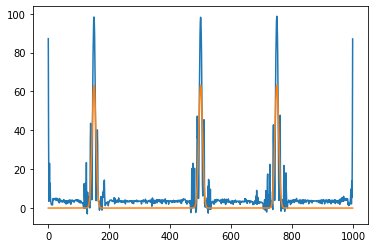

25496.25390625


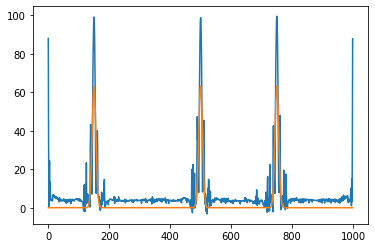

28408.2578125


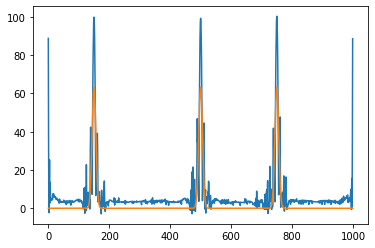

27375.244140625


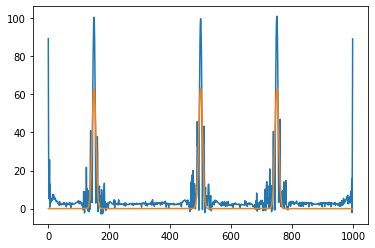

23188.171875


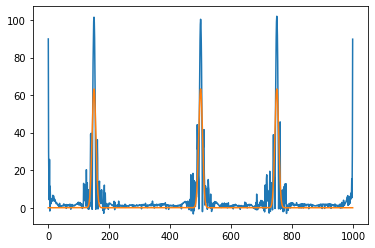

20096.021484375


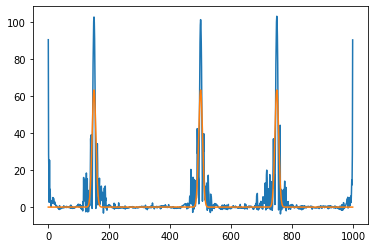

20512.4921875


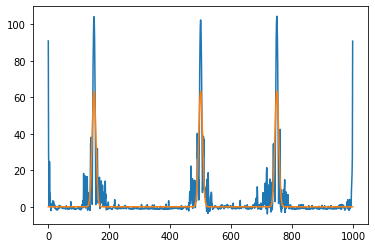

24085.234375


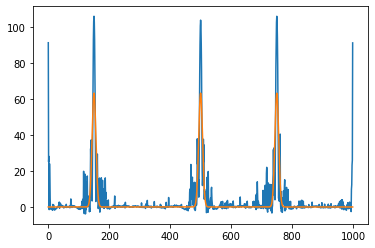

19688.1796875


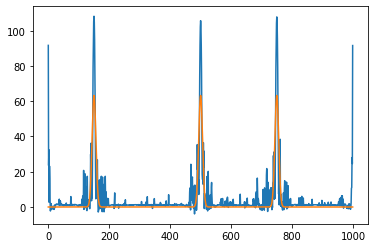

17445.9609375


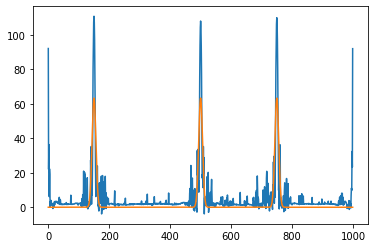

18376.005859375


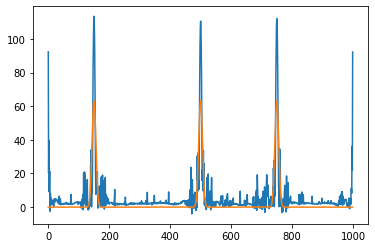

19148.0703125


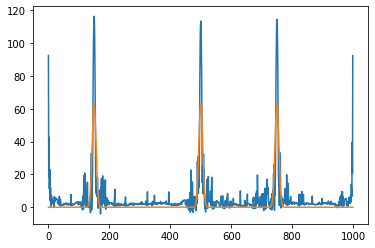

18839.029296875


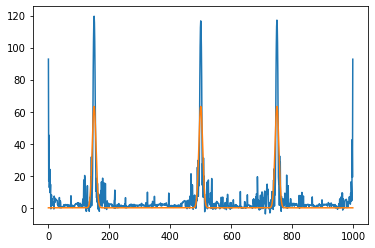

16419.04296875


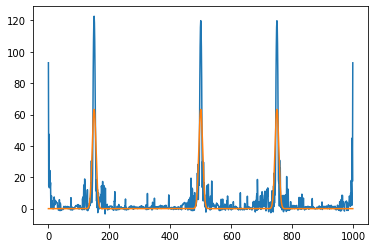

15414.474609375


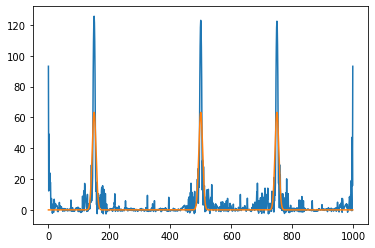

15515.0869140625


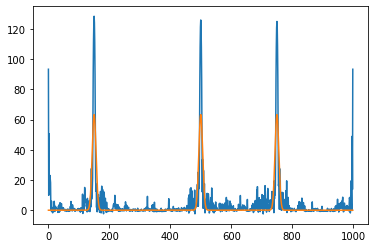

14112.408203125


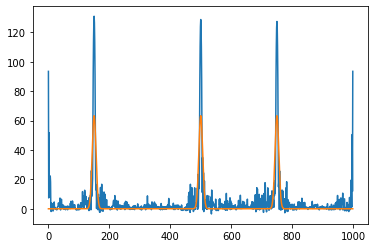

13897.6005859375


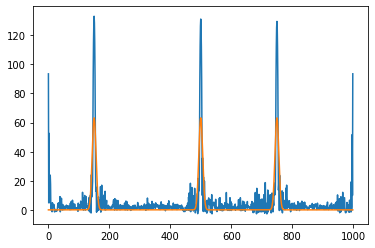

15478.1953125


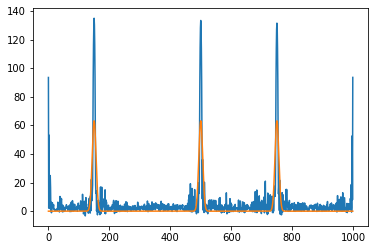

15720.39453125


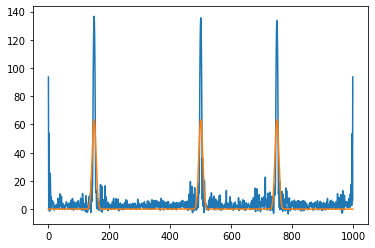

16327.599609375


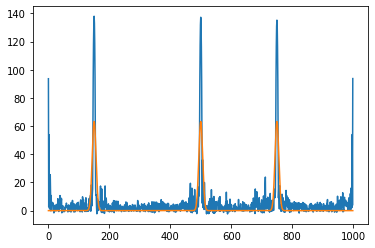

15891.53125


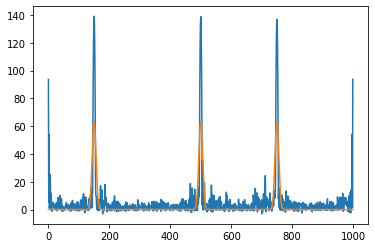

16043.0771484375


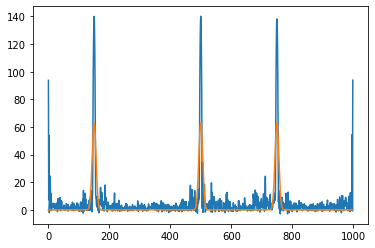

15156.69140625


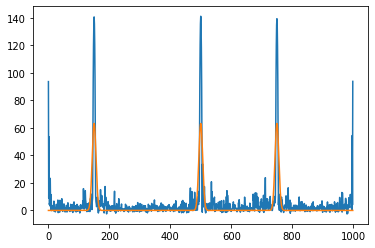

14444.623046875


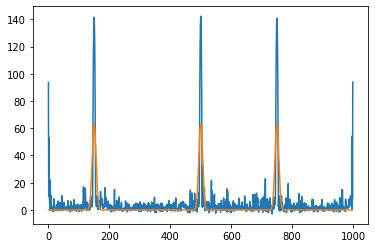

14358.09375


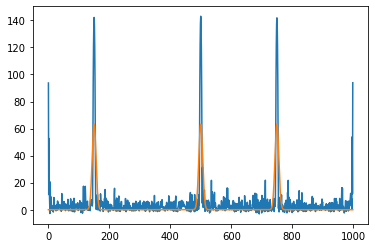

15687.3017578125


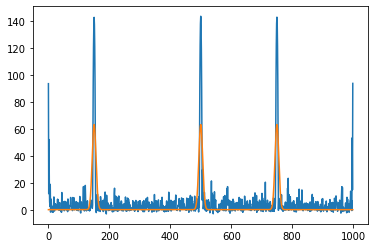

16357.48828125


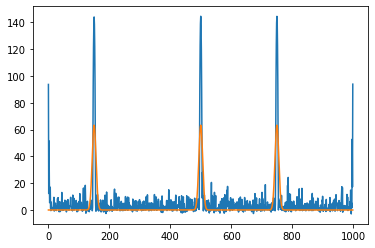

15892.234375


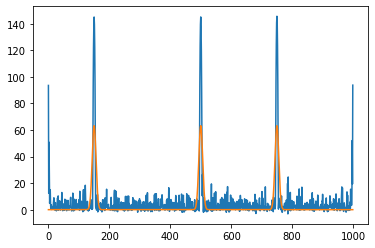

16051.869140625


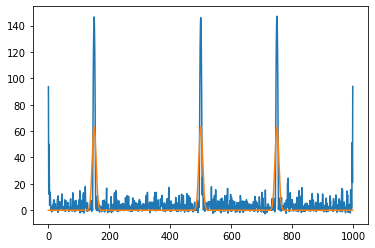

16403.60546875


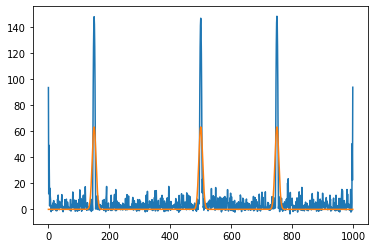

16461.6328125


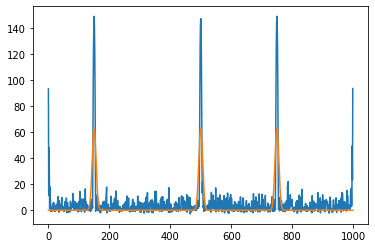

16652.0390625


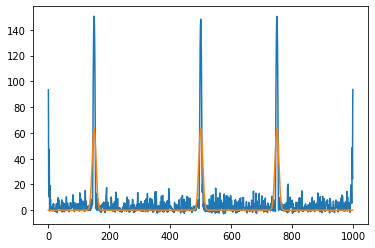

16896.78125


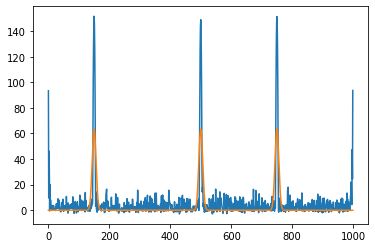

16473.927734375


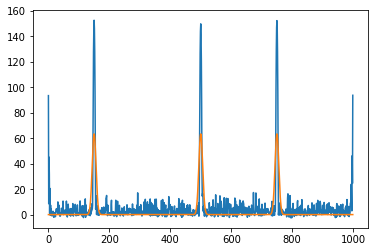

15907.8369140625


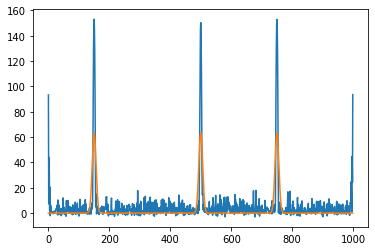

16360.5625


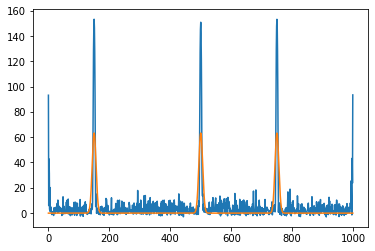

16757.841796875


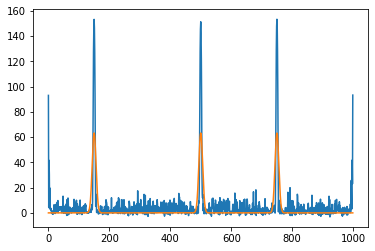

16230.482421875


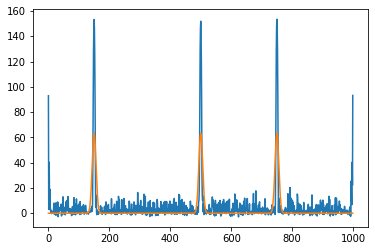

15928.908203125


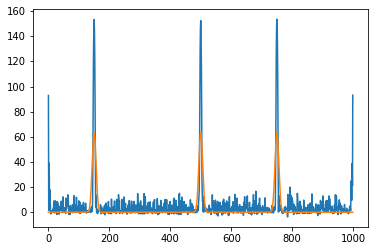

15890.05859375


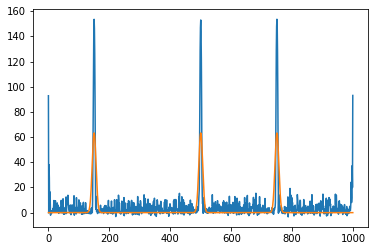

16749.4765625


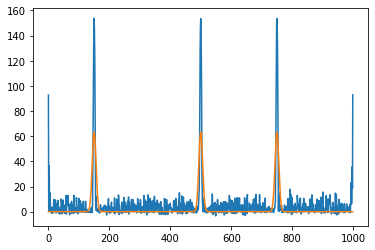

16890.611328125


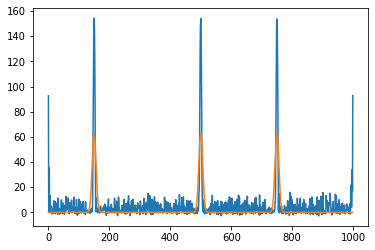

16335.2626953125


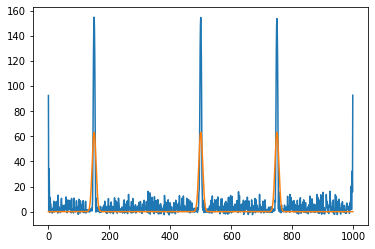

15919.33203125


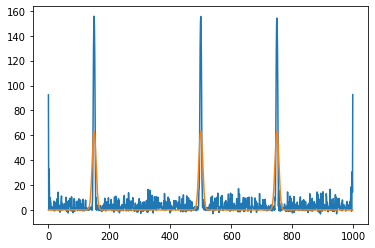

16108.5234375


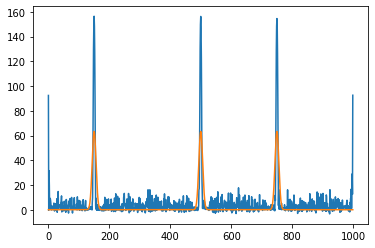

17087.50390625


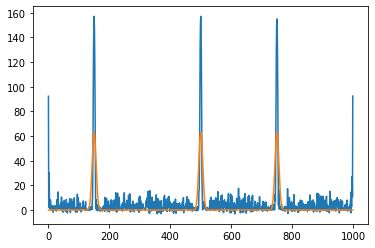

16483.19921875


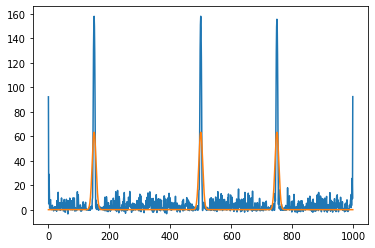

16147.6796875


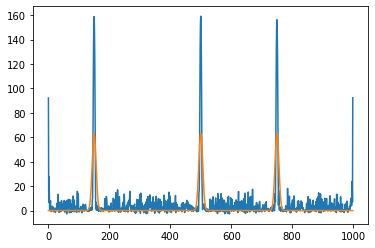

15824.927734375


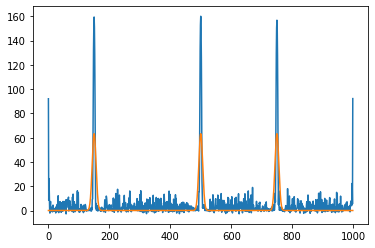

15875.341796875


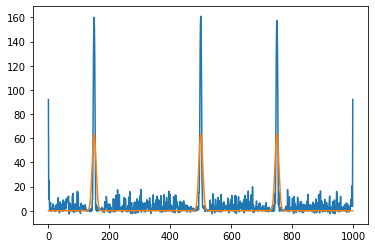

15587.603515625


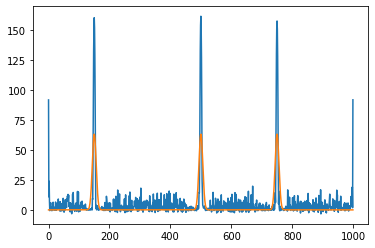

16716.029296875


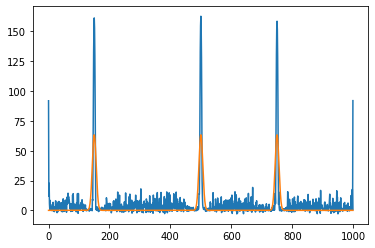

16488.056640625


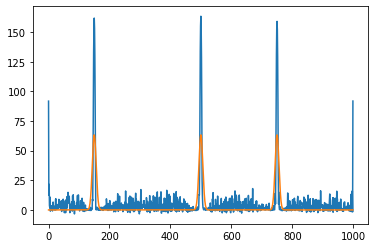

17042.048828125


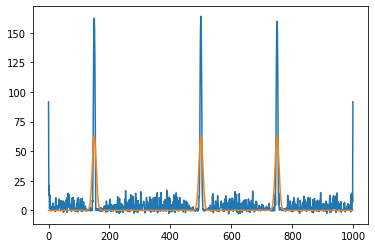

16006.0078125


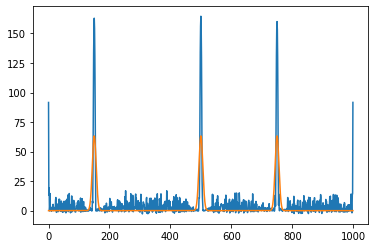

16234.87890625


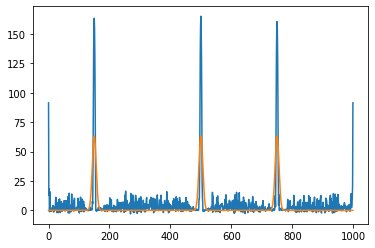

16294.1103515625


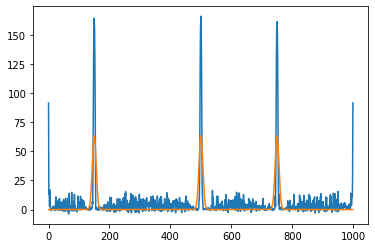

16720.00390625


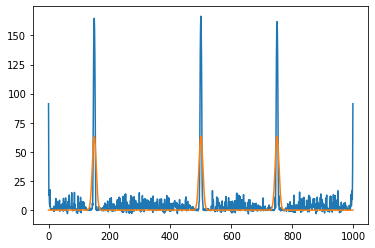

16446.7109375


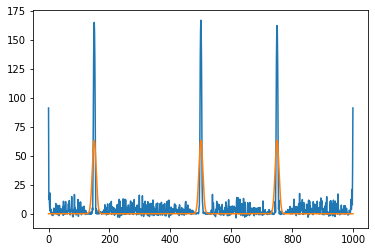

16313.7607421875


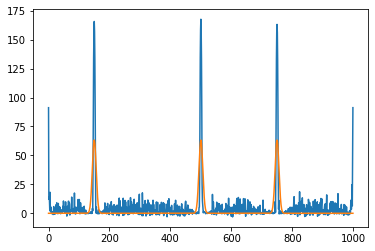

16013.826171875


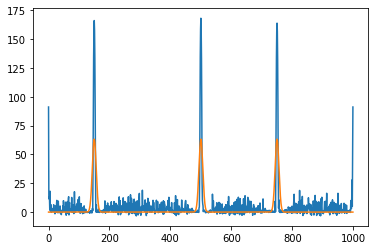

16908.58984375


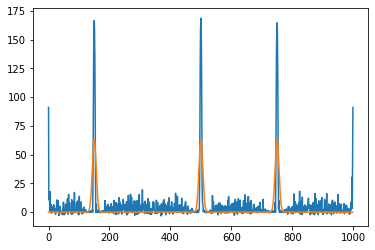

15962.865234375


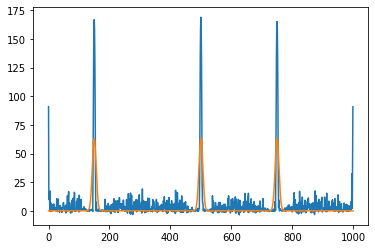

16075.369140625


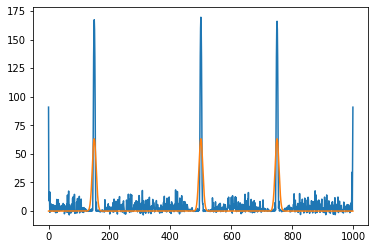

16498.103515625


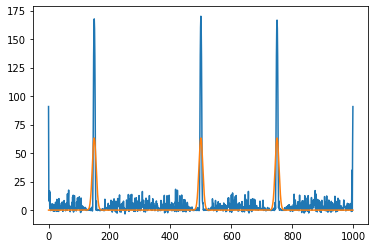

15628.83984375


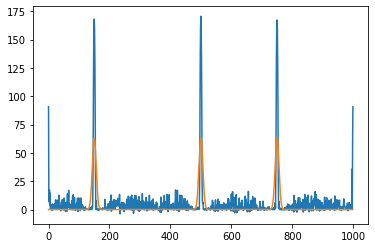

15664.521484375


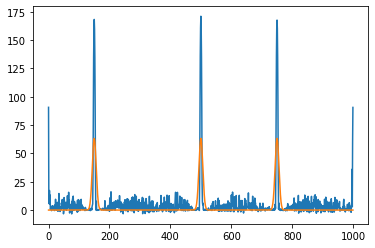

16550.591796875


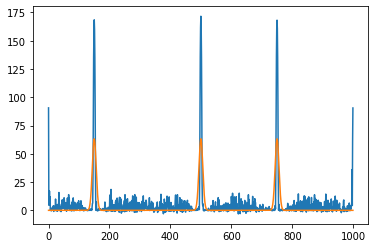

14950.1611328125


KeyboardInterrupt: 

In [24]:
##Performance of l2-network-nonnegative constraint
x1 = torch.zeros((1000,1))  # initial value of x
x1.requires_grad_(True)  # turn on gradients w.r.t. x
optimizer = torch.optim.Adam([x1], lr=15)
beta=500
beta1 = 500
beta3 = 5
for iter in range(3000):  # for N iterations...
    #with torch.no_grad():
        #Fw = torch.matrix_power(A, int(Ncount))
            
        
    optimizer.zero_grad()  # zero the gradients 
    #loss = torch.sum((Fw.matmul(x1) - meas)**2) + beta3*torch.sum(torch.abs(x1))+ beta1*torch.norm(x1[x1<0])#+ beta*net1(x1.T) +beta1*torch.norm(x1[x1<0])#+ beta*net1(x1.T)#  # compute the loss
    loss = torch.sum((Fw.matmul(x1) - meas)**2) + beta*(net1(x1.T)) +beta1*torch.norm(x1[x1<0]) + beta3*torch.norm(x1,1) #+ beta*net1(x1.T)
    loss.backward()  # take gradients of the loss
    optimizer.step()  # take a gradient step (changes x!)       
    print(loss.item())    
    plt.plot(x1.detach().numpy())
    plt.plot(meas)
    plt.pause(0.2)

In [53]:
def get_X(Ncount):
    
    x1 = torch.zeros((1000,1))  # initial value of x
    x1.requires_grad_(True)  # turn on gradients w.r.t. x
    optimizer = torch.optim.Adam([x1], lr=8e-3)
    beta=5000
    beta1 = 100
    beta3 = 5
    for iter in range(3000):  # for N iterations...
        with torch.no_grad():
            Fw = torch.matrix_power(A, int(Ncount))
            
        
        optimizer.zero_grad()  # zero the gradients 
        loss = torch.sum((Fw.matmul(x1) - meas)**2) #+ beta3*torch.sum(torch.abs(x1))#+ beta*net1(x1.T) +beta1*torch.norm(x1[x1<0])#+ beta*net1(x1.T)#  # compute the loss
        #loss = torch.sum((Fw.matmul(x1) - meas)**2) + beta*net1(x1.T) +beta1*torch.norm(x1[x1<0]) + beta3*torch.norm(x1,2) #+ beta*net1(x1.T)
        loss.backward()  # take gradients of the loss
        optimizer.step()  # take a gradient step (changes x!)       
    print(loss.item())    
    plt.plot(x1.detach().numpy())
    plt.plot(meas)
    plt.pause(0.2)
    
    return x1       

def get_Ncount(p):
    Nmax=1500
    E=torch.zeros(Nmax)
    r=p
    for Nc in range(0,Nmax):
        r=A@r
        E[Nc]=torch.norm(r-meas,2)
    ind = torch.where(E==torch.min(E))[0]
    return ind

def l2min_grad(meas,u,A,t0=500,step =1e1,iters=1000):
    u = A@u
    D, U = torch.eig(A,eigenvectors=True)
    v = U.T @ meas
    v0 = U.T @ u
    t=t0
    for i in range(0,iters):
        Gr = gradient(D[:,0],t,v0,v)
        t = t - step*Gr/torch.abs(Gr)
        print(t)
        #print(Gr)
    #print(t)    
    return t

def gradient(d,t,v0,v):
    return torch.sum(torch.pow(d,t)*torch.log(d+1e-7*torch.ones_like(d))*(torch.pow(torch.diag(d),t)@v0 - v)* v0)


In [55]:
t = l2min_grad(meas,u,A,t0=200,step =1e1,iters=100)



tensor(210.)
tensor(220.)
tensor(230.)
tensor(240.)
tensor(250.)
tensor(260.)
tensor(270.)
tensor(280.)
tensor(290.)
tensor(300.)
tensor(310.)
tensor(320.)
tensor(330.)
tensor(340.)
tensor(350.)
tensor(360.)
tensor(370.)
tensor(380.)
tensor(390.)
tensor(400.)
tensor(410.)
tensor(420.)
tensor(430.)
tensor(440.)
tensor(450.)
tensor(460.)
tensor(470.)
tensor(480.)
tensor(490.)
tensor(500.)
tensor(510.)
tensor(520.)
tensor(530.)
tensor(540.)
tensor(550.)
tensor(560.)
tensor(570.)
tensor(580.)
tensor(590.)
tensor(600.)
tensor(610.)
tensor(620.)
tensor(630.)
tensor(640.)
tensor(650.)
tensor(660.)
tensor(670.)
tensor(680.)
tensor(690.)
tensor(700.)
tensor(710.)
tensor(720.)
tensor(730.)
tensor(740.)
tensor(750.)
tensor(760.)
tensor(770.)
tensor(780.)
tensor(790.)
tensor(800.)
tensor(810.)
tensor(820.)
tensor(830.)
tensor(840.)
tensor(850.)
tensor(860.)
tensor(870.)
tensor(880.)
tensor(890.)
tensor(900.)
tensor(910.)
tensor(920.)
tensor(930.)
tensor(940.)
tensor(950.)
tensor(960.)
tensor(970.)

In [59]:
import cvxpy as cp

# Create variable.
x_l1 = cp.Variable(shape=(N,1))
eps=1  ##box constraint
# Create constraint.
#constraints = [Fw*x_l1 =  meas]
constraints = [cp.norm(Fw@x_l1-meas, 2) <=5, cp.norm(Fw@x_l1-meas, 2) >=7 ]


# Form objective.
obj = cp.Minimize(cp.norm(x_l1, 1))

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()
print("status: {}".format(prob.status))


# Number of nonzero elements in the solution (its cardinality or diversity).
nnz_l1 = (np.absolute(x_l1.value) > 0.01).sum()
print('Found a feasible x in R^{} that has {} nonzeros.'.format(N, nnz_l1))
print("optimal objective value: {}".format(obj.value))

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
7.0 <= Pnorm(reshape([[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00013686 0.00682598 0.01279738 ... 0.         0.         0.        ]
 [0.00025656 0.01279738 0.02406358 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.02406374 0.01279746 0.00025656]
 [0.         0.         0.         ... 0.01279746 0.00682602 0.00013686]
 [0.         0.         0.         ... 0.         0.         0.        ]] @ var158 + -[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.40129846e-41]
 [7.98740125e-41]
 [4.35803822e-40]
 [2.37239830e-39]
 [1.26200940e-38]
 [6.64075342e-38]
 [3.45595223e-37]
 [1.77905768e-36]
 [9.05835775e-36]
 [4.56149664e-35]
 [2.27156271e-34]
 [1.11856589e-33]
 [5.44599553e-33]
 [2.62138649e-32]
 [1.24732963e-31]
 [5.86658103e-31]
 [2.72708821e-30]
 [1.25279531e-29]
 [5.68699247e-29]
 [2.55071149e-28]
 [1.13023863e-27]
 [4.94722600e-27]
 [2.13888834e-26]
 [9.13273145e-26]
 [3.85078778e-25]
 [1.60318772e-24]
 [6.58951686e-24]
 [2.67365250e-23]
 [1.07074249e-22]
 [4.23194139e-22]
 [1.65049290e-21]
 [6.35112829e-21]
 [2.41098139e-20]
 [9.02785761e-20]
 [3.33398558e-19]
 [1.21414584e-18]
 [4.35957932e-18]
 [1.54320006e-17]
 [5.38443823e-17]
 [1.85154388e-16]
 [6.27389363e-16]
 [2.09451300e-15]
 [6.88815409e-15]
 [2.23114221e-14]
 [7.11681284e-14]
 [2.23514471e-13]
 [6.91058105e-13]
 [2.10299161e-12]
 [6.29794741e-12]
 [1.85576051e-11]
 [5.37932615e-11]
 [1.53368943e-10]
 [4.30001257e-10]
 [1.18533916e-09]
 [3.21197891e-09]
 [8.55411830e-09]
 [2.23853913e-08]
 [5.75510946e-08]
 [1.45329494e-07]
 [3.60392420e-07]
 [8.77462526e-07]
 [2.09710811e-06]
 [4.91880382e-06]
 [1.13201177e-05]
 [2.55564428e-05]
 [5.65863993e-05]
 [1.22854093e-04]
 [2.61478621e-04]
 [5.45448216e-04]
 [1.11492048e-03]
 [2.23258766e-03]
 [4.37873648e-03]
 [8.40940699e-03]
 [1.58110205e-02]
 [2.90960148e-02]
 [5.23947962e-02]
 [9.23052430e-02]
 [1.59056515e-01]
 [2.68020362e-01]
 [4.41551268e-01]
 [7.11047709e-01]
 [1.11899996e+00]
 [1.72062469e+00]
 [2.58452415e+00]
 [3.79166436e+00]
 [5.43192148e+00]
 [7.59755850e+00]
 [1.03733244e+01]
 [1.38234196e+01]
 [1.79763393e+01]
 [2.28094082e+01]
 [2.82356453e+01]
 [3.40958443e+01]
 [4.01586876e+01]
 [4.61308823e+01]
 [5.16777611e+01]
 [5.64530220e+01]
 [6.01339836e+01]
 [6.24576988e+01]
 [6.32522240e+01]
 [6.24577103e+01]
 [6.01339874e+01]
 [5.64530296e+01]
 [5.16777649e+01]
 [4.61308861e+01]
 [4.01586914e+01]
 [3.40958519e+01]
 [2.82356510e+01]
 [2.28094044e+01]
 [1.79763374e+01]
 [1.38234196e+01]
 [1.03733263e+01]
 [7.59756041e+00]
 [5.43192196e+00]
 [3.79166508e+00]
 [2.58452392e+00]
 [1.72062445e+00]
 [1.11900020e+00]
 [7.11047888e-01]
 [4.41551298e-01]
 [2.68020332e-01]
 [1.59056500e-01]
 [9.23052505e-02]
 [5.23947924e-02]
 [2.90960111e-02]
 [1.58110205e-02]
 [8.40940699e-03]
 [4.37873462e-03]
 [2.23258766e-03]
 [1.11492060e-03]
 [5.45448216e-04]
 [2.61478592e-04]
 [1.22854122e-04]
 [5.65864029e-05]
 [2.55564428e-05]
 [1.13201186e-05]
 [4.91880519e-06]
 [2.09710788e-06]
 [8.77462355e-07]
 [3.60392448e-07]
 [1.45329523e-07]
 [5.75511585e-08]
 [2.23854233e-08]
 [8.55413251e-09]
 [3.21198290e-09]
 [1.18534049e-09]
 [4.30001784e-10]
 [1.53369137e-10]
 [5.37933240e-11]
 [1.85576207e-11]
 [6.29795391e-12]
 [2.10299356e-12]
 [6.91058810e-13]
 [2.23514742e-13]
 [7.11682029e-14]
 [2.23114458e-14]
 [6.88816002e-15]
 [2.09451491e-15]
 [6.27390210e-16]
 [1.85154586e-16]
 [5.38444352e-17]
 [1.54320155e-17]
 [4.35958304e-18]
 [1.21414697e-18]
 [3.33398868e-19]
 [9.02786407e-20]
 [2.41098382e-20]
 [6.35113354e-21]
 [1.65049462e-21]
 [4.23194543e-22]
 [1.07074350e-22]
 [2.67365471e-23]
 [6.58952317e-24]
 [1.60318900e-24]
 [3.85079049e-25]
 [9.13273884e-26]
 [2.13889019e-26]
 [4.94723023e-27]
 [1.13023960e-27]
 [2.55071414e-28]
 [5.68699728e-29]
 [1.25279606e-29]
 [2.72709122e-30]
 [5.86658527e-31]
 [1.24733046e-31]
 [2.62138943e-32]
 [5.44599957e-33]
 [1.11856635e-33]
 [2.27156408e-34]
 [4.56150095e-35]
 [9.05836062e-36]
 [1.77906055e-36]
 [3.45595223e-37]
 [6.64075342e-38]
 [1.26200940e-38]
 [2.37239830e-39]
 [4.35803822e-40]
 [7.98740125e-41]
 [1.40129846e-41]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.40129846e-41]
 [7.98740125e-41]
 [4.35803822e-40]
 [2.37239830e-39]
 [1.26200940e-38]
 [6.64075342e-38]
 [3.45595223e-37]
 [1.77906055e-36]
 [9.05836851e-36]
 [4.56150296e-35]
 [2.27156500e-34]
 [1.11856709e-33]
 [5.44600251e-33]
 [2.62139002e-32]
 [1.24733140e-31]
 [5.86658856e-31]
 [2.72709273e-30]
 [1.25279674e-29]
 [5.68699969e-29]
 [2.55071510e-28]
 [1.13024027e-27]
 [4.94723293e-27]
 [2.13889127e-26]
 [9.13274624e-26]
 [3.85079345e-25]
 [1.60318999e-24]
 [6.58952711e-24]
 [2.67365597e-23]
 [1.07074400e-22]
 [4.23194846e-22]
 [1.65049543e-21]
 [6.35113798e-21]
 [2.41098527e-20]
 [9.02787182e-20]
 [3.33399023e-19]
 [1.21414780e-18]
 [4.35958635e-18]
 [1.54320287e-17]
 [5.38444716e-17]
 [1.85154732e-16]
 [6.27390475e-16]
 [2.09451618e-15]
 [6.88816637e-15]
 [2.23114662e-14]
 [7.11682571e-14]
 [2.23514919e-13]
 [6.91059514e-13]
 [2.10299551e-12]
 [6.29796085e-12]
 [1.85576433e-11]
 [5.37933829e-11]
 [1.53369289e-10]
 [4.30002256e-10]
 [1.18534182e-09]
 [3.21198645e-09]
 [8.55414140e-09]
 [2.23854482e-08]
 [5.75512402e-08]
 [1.45329878e-07]
 [3.60393386e-07]
 [8.77464856e-07]
 [2.09711402e-06]
 [4.91881747e-06]
 [1.13201531e-05]
 [2.55565174e-05]
 [5.65865885e-05]
 [1.22854530e-04]
 [2.61479436e-04]
 [5.45450137e-04]
 [1.11492444e-03]
 [2.23259628e-03]
 [4.37875185e-03]
 [8.40943959e-03]
 [1.58110820e-02]
 [2.90961340e-02]
 [5.23950271e-02]
 [9.23056528e-02]
 [1.59057215e-01]
 [2.68021584e-01]
 [4.41553533e-01]
 [7.11051702e-01]
 [1.11900592e+00]
 [1.72063458e+00]
 [2.58453989e+00]
 [3.79168868e+00]
 [5.43195868e+00]
 [7.59761333e+00]
 [1.03734055e+01]
 [1.38235340e+01]
 [1.79764957e+01]
 [2.28096180e+01]
 [2.82359295e+01]
 [3.40962181e+01]
 [4.01591606e+01]
 [4.61314735e+01]
 [5.16784859e+01]
 [5.64538193e+01]
 [6.01347847e+01]
 [6.24584579e+01]
 [6.32528458e+01]
 [6.24582062e+01]
 [6.01343880e+01]
 [5.64533424e+01]
 [5.16780167e+01]
 [4.61310692e+01]
 [4.01588287e+01]
 [3.40959587e+01]
 [2.82357235e+01]
 [2.28094597e+01]
 [1.79763718e+01]
 [1.38234434e+01]
 [1.03733416e+01]
 [7.59757042e+00]
 [5.43192816e+00]
 [3.79166865e+00]
 [2.58452654e+00]
 [1.72062612e+00]
 [1.11900103e+00]
 [7.11048424e-01]
 [4.41551566e-01]
 [2.68020481e-01]
 [1.59056574e-01]
 [9.23052877e-02]
 [5.23948111e-02]
 [2.90960204e-02]
 [1.58110242e-02]
 [8.40941165e-03]
 [4.37873602e-03]
 [2.23258859e-03]
 [1.11492083e-03]
 [5.45448391e-04]
 [2.61478621e-04]
 [1.22854137e-04]
 [5.65864138e-05]
 [2.55564464e-05]
 [1.13201204e-05]
 [4.91880610e-06]
 [2.09710811e-06]
 [8.77462469e-07]
 [3.60392448e-07]
 [1.45329494e-07]
 [5.75511052e-08]
 [2.23853949e-08]
 [8.55412008e-09]
 [3.21197957e-09]
 [1.18533905e-09]
 [4.30001340e-10]
 [1.53368956e-10]
 [5.37932615e-11]
 [1.85575999e-11]
 [6.29794741e-12]
 [2.10299161e-12]
 [6.91058105e-13]
 [2.23514498e-13]
 [7.11681487e-14]
 [2.23114255e-14]
 [6.88815578e-15]
 [2.09451364e-15]
 [6.27389628e-16]
 [1.85154401e-16]
 [5.38443856e-17]
 [1.54320023e-17]
 [4.35957890e-18]
 [1.21414604e-18]
 [3.33398636e-19]
 [9.02785761e-20]
 [2.41098204e-20]
 [6.35112829e-21]
 [1.65049300e-21]
 [4.23194391e-22]
 [1.07074262e-22]
 [2.67365187e-23]
 [6.58951922e-24]
 [1.60318792e-24]
 [3.85078778e-25]
 [9.13273453e-26]
 [2.13889034e-26]
 [4.94722908e-27]
 [1.13023960e-27]
 [2.55071390e-28]
 [5.68699668e-29]
 [1.25279606e-29]
 [2.72709160e-30]
 [5.86658480e-31]
 [1.24733057e-31]
 [2.62138884e-32]
 [5.44599994e-33]
 [1.11856645e-33]
 [2.27156431e-34]
 [4.56150066e-35]
 [9.05836062e-36]
 [1.77906055e-36]
 [3.45595223e-37]
 [6.64075342e-38]
 [1.26200940e-38]
 [2.37239830e-39]
 [4.35803822e-40]
 [7.98740125e-41]
 [1.40129846e-41]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.40129846e-41]
 [7.98740125e-41]
 [4.35803822e-40]
 [2.37239830e-39]
 [1.26200940e-38]
 [6.64075342e-38]
 [3.45595223e-37]
 [1.77905768e-36]
 [9.05835775e-36]
 [4.56149664e-35]
 [2.27156271e-34]
 [1.11856589e-33]
 [5.44599553e-33]
 [2.62138649e-32]
 [1.24732963e-31]
 [5.86658103e-31]
 [2.72708821e-30]
 [1.25279531e-29]
 [5.68699247e-29]
 [2.55071149e-28]
 [1.13023863e-27]
 [4.94722600e-27]
 [2.13888834e-26]
 [9.13273145e-26]
 [3.85078778e-25]
 [1.60318772e-24]
 [6.58951686e-24]
 [2.67365250e-23]
 [1.07074249e-22]
 [4.23194139e-22]
 [1.65049290e-21]
 [6.35112829e-21]
 [2.41098139e-20]
 [9.02785761e-20]
 [3.33398558e-19]
 [1.21414584e-18]
 [4.35957932e-18]
 [1.54320006e-17]
 [5.38443823e-17]
 [1.85154388e-16]
 [6.27389363e-16]
 [2.09451300e-15]
 [6.88815409e-15]
 [2.23114221e-14]
 [7.11681284e-14]
 [2.23514471e-13]
 [6.91058105e-13]
 [2.10299161e-12]
 [6.29794741e-12]
 [1.85576051e-11]
 [5.37932615e-11]
 [1.53368943e-10]
 [4.30001257e-10]
 [1.18533916e-09]
 [3.21197891e-09]
 [8.55411830e-09]
 [2.23853913e-08]
 [5.75510946e-08]
 [1.45329494e-07]
 [3.60392420e-07]
 [8.77462526e-07]
 [2.09710811e-06]
 [4.91880382e-06]
 [1.13201177e-05]
 [2.55564428e-05]
 [5.65863993e-05]
 [1.22854093e-04]
 [2.61478621e-04]
 [5.45448216e-04]
 [1.11492048e-03]
 [2.23258766e-03]
 [4.37873648e-03]
 [8.40940699e-03]
 [1.58110205e-02]
 [2.90960148e-02]
 [5.23947962e-02]
 [9.23052430e-02]
 [1.59056515e-01]
 [2.68020362e-01]
 [4.41551268e-01]
 [7.11047709e-01]
 [1.11899996e+00]
 [1.72062469e+00]
 [2.58452415e+00]
 [3.79166436e+00]
 [5.43192148e+00]
 [7.59755850e+00]
 [1.03733244e+01]
 [1.38234196e+01]
 [1.79763393e+01]
 [2.28094082e+01]
 [2.82356453e+01]
 [3.40958443e+01]
 [4.01586876e+01]
 [4.61308823e+01]
 [5.16777611e+01]
 [5.64530220e+01]
 [6.01339836e+01]
 [6.24576988e+01]
 [6.32522240e+01]
 [6.24577103e+01]
 [6.01339874e+01]
 [5.64530258e+01]
 [5.16777649e+01]
 [4.61308861e+01]
 [4.01586914e+01]
 [3.40958481e+01]
 [2.82356529e+01]
 [2.28094082e+01]
 [1.79763412e+01]
 [1.38234215e+01]
 [1.03733292e+01]
 [7.59756088e+00]
 [5.43192244e+00]
 [3.79166555e+00]
 [2.58452535e+00]
 [1.72062659e+00]
 [1.11900258e+00]
 [7.11049855e-01]
 [4.41552401e-01]
 [2.68021047e-01]
 [1.59056887e-01]
 [9.23054442e-02]
 [5.23949079e-02]
 [2.90960725e-02]
 [1.58110503e-02]
 [8.40942282e-03]
 [4.37874347e-03]
 [2.23259185e-03]
 [1.11492258e-03]
 [5.45449264e-04]
 [2.61479028e-04]
 [1.22854311e-04]
 [5.65864939e-05]
 [2.55564810e-05]
 [1.13201359e-05]
 [4.91881156e-06]
 [2.09711061e-06]
 [8.77463663e-07]
 [3.60392903e-07]
 [1.45329693e-07]
 [5.75511798e-08]
 [2.23854215e-08]
 [8.55413163e-09]
 [3.21198290e-09]
 [1.18534049e-09]
 [4.30001756e-10]
 [1.53369123e-10]
 [5.37933170e-11]
 [1.85576207e-11]
 [6.29795435e-12]
 [2.10299334e-12]
 [6.91058810e-13]
 [2.23514742e-13]
 [7.11682164e-14]
 [2.23114475e-14]
 [6.88816171e-15]
 [2.09451533e-15]
 [6.27390210e-16]
 [1.85154600e-16]
 [5.38444319e-17]
 [1.54320155e-17]
 [4.35958263e-18]
 [1.21414708e-18]
 [3.33398920e-19]
 [9.02786536e-20]
 [2.41098398e-20]
 [6.35113313e-21]
 [1.65049442e-21]
 [4.23194745e-22]
 [1.07074325e-22]
 [2.67365376e-23]
 [6.58952554e-24]
 [1.60318900e-24]
 [3.85079049e-25]
 [9.13273699e-26]
 [2.13889034e-26]
 [4.94722831e-27]
 [1.13023960e-27]
 [2.55071366e-28]
 [5.68699608e-29]
 [1.25279621e-29]
 [2.72709160e-30]
 [5.86658480e-31]
 [1.24733057e-31]
 [2.62138855e-32]
 [5.44599957e-33]
 [1.11856645e-33]
 [2.27156408e-34]
 [4.56150066e-35]
 [9.05835918e-36]
 [1.77905911e-36]
 [3.45595223e-37]
 [6.64075342e-38]
 [1.26200940e-38]
 [2.37239830e-39]
 [4.35803822e-40]
 [7.98740125e-41]
 [1.40129846e-41]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]], (1000,), F), 2) , because the following subexpressions are not:
|--  7.0 <= Pnorm(reshape([[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00013686 0.00682598 0.01279738 ... 0.         0.         0.        ]
 [0.00025656 0.01279738 0.02406358 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.02406374 0.01279746 0.00025656]
 [0.         0.         0.         ... 0.01279746 0.00682602 0.00013686]
 [0.         0.         0.         ... 0.         0.         0.        ]] @ var158 + -[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.40129846e-41]
 [7.98740125e-41]
 [4.35803822e-40]
 [2.37239830e-39]
 [1.26200940e-38]
 [6.64075342e-38]
 [3.45595223e-37]
 [1.77905768e-36]
 [9.05835775e-36]
 [4.56149664e-35]
 [2.27156271e-34]
 [1.11856589e-33]
 [5.44599553e-33]
 [2.62138649e-32]
 [1.24732963e-31]
 [5.86658103e-31]
 [2.72708821e-30]
 [1.25279531e-29]
 [5.68699247e-29]
 [2.55071149e-28]
 [1.13023863e-27]
 [4.94722600e-27]
 [2.13888834e-26]
 [9.13273145e-26]
 [3.85078778e-25]
 [1.60318772e-24]
 [6.58951686e-24]
 [2.67365250e-23]
 [1.07074249e-22]
 [4.23194139e-22]
 [1.65049290e-21]
 [6.35112829e-21]
 [2.41098139e-20]
 [9.02785761e-20]
 [3.33398558e-19]
 [1.21414584e-18]
 [4.35957932e-18]
 [1.54320006e-17]
 [5.38443823e-17]
 [1.85154388e-16]
 [6.27389363e-16]
 [2.09451300e-15]
 [6.88815409e-15]
 [2.23114221e-14]
 [7.11681284e-14]
 [2.23514471e-13]
 [6.91058105e-13]
 [2.10299161e-12]
 [6.29794741e-12]
 [1.85576051e-11]
 [5.37932615e-11]
 [1.53368943e-10]
 [4.30001257e-10]
 [1.18533916e-09]
 [3.21197891e-09]
 [8.55411830e-09]
 [2.23853913e-08]
 [5.75510946e-08]
 [1.45329494e-07]
 [3.60392420e-07]
 [8.77462526e-07]
 [2.09710811e-06]
 [4.91880382e-06]
 [1.13201177e-05]
 [2.55564428e-05]
 [5.65863993e-05]
 [1.22854093e-04]
 [2.61478621e-04]
 [5.45448216e-04]
 [1.11492048e-03]
 [2.23258766e-03]
 [4.37873648e-03]
 [8.40940699e-03]
 [1.58110205e-02]
 [2.90960148e-02]
 [5.23947962e-02]
 [9.23052430e-02]
 [1.59056515e-01]
 [2.68020362e-01]
 [4.41551268e-01]
 [7.11047709e-01]
 [1.11899996e+00]
 [1.72062469e+00]
 [2.58452415e+00]
 [3.79166436e+00]
 [5.43192148e+00]
 [7.59755850e+00]
 [1.03733244e+01]
 [1.38234196e+01]
 [1.79763393e+01]
 [2.28094082e+01]
 [2.82356453e+01]
 [3.40958443e+01]
 [4.01586876e+01]
 [4.61308823e+01]
 [5.16777611e+01]
 [5.64530220e+01]
 [6.01339836e+01]
 [6.24576988e+01]
 [6.32522240e+01]
 [6.24577103e+01]
 [6.01339874e+01]
 [5.64530296e+01]
 [5.16777649e+01]
 [4.61308861e+01]
 [4.01586914e+01]
 [3.40958519e+01]
 [2.82356510e+01]
 [2.28094044e+01]
 [1.79763374e+01]
 [1.38234196e+01]
 [1.03733263e+01]
 [7.59756041e+00]
 [5.43192196e+00]
 [3.79166508e+00]
 [2.58452392e+00]
 [1.72062445e+00]
 [1.11900020e+00]
 [7.11047888e-01]
 [4.41551298e-01]
 [2.68020332e-01]
 [1.59056500e-01]
 [9.23052505e-02]
 [5.23947924e-02]
 [2.90960111e-02]
 [1.58110205e-02]
 [8.40940699e-03]
 [4.37873462e-03]
 [2.23258766e-03]
 [1.11492060e-03]
 [5.45448216e-04]
 [2.61478592e-04]
 [1.22854122e-04]
 [5.65864029e-05]
 [2.55564428e-05]
 [1.13201186e-05]
 [4.91880519e-06]
 [2.09710788e-06]
 [8.77462355e-07]
 [3.60392448e-07]
 [1.45329523e-07]
 [5.75511585e-08]
 [2.23854233e-08]
 [8.55413251e-09]
 [3.21198290e-09]
 [1.18534049e-09]
 [4.30001784e-10]
 [1.53369137e-10]
 [5.37933240e-11]
 [1.85576207e-11]
 [6.29795391e-12]
 [2.10299356e-12]
 [6.91058810e-13]
 [2.23514742e-13]
 [7.11682029e-14]
 [2.23114458e-14]
 [6.88816002e-15]
 [2.09451491e-15]
 [6.27390210e-16]
 [1.85154586e-16]
 [5.38444352e-17]
 [1.54320155e-17]
 [4.35958304e-18]
 [1.21414697e-18]
 [3.33398868e-19]
 [9.02786407e-20]
 [2.41098382e-20]
 [6.35113354e-21]
 [1.65049462e-21]
 [4.23194543e-22]
 [1.07074350e-22]
 [2.67365471e-23]
 [6.58952317e-24]
 [1.60318900e-24]
 [3.85079049e-25]
 [9.13273884e-26]
 [2.13889019e-26]
 [4.94723023e-27]
 [1.13023960e-27]
 [2.55071414e-28]
 [5.68699728e-29]
 [1.25279606e-29]
 [2.72709122e-30]
 [5.86658527e-31]
 [1.24733046e-31]
 [2.62138943e-32]
 [5.44599957e-33]
 [1.11856635e-33]
 [2.27156408e-34]
 [4.56150095e-35]
 [9.05836062e-36]
 [1.77906055e-36]
 [3.45595223e-37]
 [6.64075342e-38]
 [1.26200940e-38]
 [2.37239830e-39]
 [4.35803822e-40]
 [7.98740125e-41]
 [1.40129846e-41]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.40129846e-41]
 [7.98740125e-41]
 [4.35803822e-40]
 [2.37239830e-39]
 [1.26200940e-38]
 [6.64075342e-38]
 [3.45595223e-37]
 [1.77906055e-36]
 [9.05836851e-36]
 [4.56150296e-35]
 [2.27156500e-34]
 [1.11856709e-33]
 [5.44600251e-33]
 [2.62139002e-32]
 [1.24733140e-31]
 [5.86658856e-31]
 [2.72709273e-30]
 [1.25279674e-29]
 [5.68699969e-29]
 [2.55071510e-28]
 [1.13024027e-27]
 [4.94723293e-27]
 [2.13889127e-26]
 [9.13274624e-26]
 [3.85079345e-25]
 [1.60318999e-24]
 [6.58952711e-24]
 [2.67365597e-23]
 [1.07074400e-22]
 [4.23194846e-22]
 [1.65049543e-21]
 [6.35113798e-21]
 [2.41098527e-20]
 [9.02787182e-20]
 [3.33399023e-19]
 [1.21414780e-18]
 [4.35958635e-18]
 [1.54320287e-17]
 [5.38444716e-17]
 [1.85154732e-16]
 [6.27390475e-16]
 [2.09451618e-15]
 [6.88816637e-15]
 [2.23114662e-14]
 [7.11682571e-14]
 [2.23514919e-13]
 [6.91059514e-13]
 [2.10299551e-12]
 [6.29796085e-12]
 [1.85576433e-11]
 [5.37933829e-11]
 [1.53369289e-10]
 [4.30002256e-10]
 [1.18534182e-09]
 [3.21198645e-09]
 [8.55414140e-09]
 [2.23854482e-08]
 [5.75512402e-08]
 [1.45329878e-07]
 [3.60393386e-07]
 [8.77464856e-07]
 [2.09711402e-06]
 [4.91881747e-06]
 [1.13201531e-05]
 [2.55565174e-05]
 [5.65865885e-05]
 [1.22854530e-04]
 [2.61479436e-04]
 [5.45450137e-04]
 [1.11492444e-03]
 [2.23259628e-03]
 [4.37875185e-03]
 [8.40943959e-03]
 [1.58110820e-02]
 [2.90961340e-02]
 [5.23950271e-02]
 [9.23056528e-02]
 [1.59057215e-01]
 [2.68021584e-01]
 [4.41553533e-01]
 [7.11051702e-01]
 [1.11900592e+00]
 [1.72063458e+00]
 [2.58453989e+00]
 [3.79168868e+00]
 [5.43195868e+00]
 [7.59761333e+00]
 [1.03734055e+01]
 [1.38235340e+01]
 [1.79764957e+01]
 [2.28096180e+01]
 [2.82359295e+01]
 [3.40962181e+01]
 [4.01591606e+01]
 [4.61314735e+01]
 [5.16784859e+01]
 [5.64538193e+01]
 [6.01347847e+01]
 [6.24584579e+01]
 [6.32528458e+01]
 [6.24582062e+01]
 [6.01343880e+01]
 [5.64533424e+01]
 [5.16780167e+01]
 [4.61310692e+01]
 [4.01588287e+01]
 [3.40959587e+01]
 [2.82357235e+01]
 [2.28094597e+01]
 [1.79763718e+01]
 [1.38234434e+01]
 [1.03733416e+01]
 [7.59757042e+00]
 [5.43192816e+00]
 [3.79166865e+00]
 [2.58452654e+00]
 [1.72062612e+00]
 [1.11900103e+00]
 [7.11048424e-01]
 [4.41551566e-01]
 [2.68020481e-01]
 [1.59056574e-01]
 [9.23052877e-02]
 [5.23948111e-02]
 [2.90960204e-02]
 [1.58110242e-02]
 [8.40941165e-03]
 [4.37873602e-03]
 [2.23258859e-03]
 [1.11492083e-03]
 [5.45448391e-04]
 [2.61478621e-04]
 [1.22854137e-04]
 [5.65864138e-05]
 [2.55564464e-05]
 [1.13201204e-05]
 [4.91880610e-06]
 [2.09710811e-06]
 [8.77462469e-07]
 [3.60392448e-07]
 [1.45329494e-07]
 [5.75511052e-08]
 [2.23853949e-08]
 [8.55412008e-09]
 [3.21197957e-09]
 [1.18533905e-09]
 [4.30001340e-10]
 [1.53368956e-10]
 [5.37932615e-11]
 [1.85575999e-11]
 [6.29794741e-12]
 [2.10299161e-12]
 [6.91058105e-13]
 [2.23514498e-13]
 [7.11681487e-14]
 [2.23114255e-14]
 [6.88815578e-15]
 [2.09451364e-15]
 [6.27389628e-16]
 [1.85154401e-16]
 [5.38443856e-17]
 [1.54320023e-17]
 [4.35957890e-18]
 [1.21414604e-18]
 [3.33398636e-19]
 [9.02785761e-20]
 [2.41098204e-20]
 [6.35112829e-21]
 [1.65049300e-21]
 [4.23194391e-22]
 [1.07074262e-22]
 [2.67365187e-23]
 [6.58951922e-24]
 [1.60318792e-24]
 [3.85078778e-25]
 [9.13273453e-26]
 [2.13889034e-26]
 [4.94722908e-27]
 [1.13023960e-27]
 [2.55071390e-28]
 [5.68699668e-29]
 [1.25279606e-29]
 [2.72709160e-30]
 [5.86658480e-31]
 [1.24733057e-31]
 [2.62138884e-32]
 [5.44599994e-33]
 [1.11856645e-33]
 [2.27156431e-34]
 [4.56150066e-35]
 [9.05836062e-36]
 [1.77906055e-36]
 [3.45595223e-37]
 [6.64075342e-38]
 [1.26200940e-38]
 [2.37239830e-39]
 [4.35803822e-40]
 [7.98740125e-41]
 [1.40129846e-41]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.40129846e-41]
 [7.98740125e-41]
 [4.35803822e-40]
 [2.37239830e-39]
 [1.26200940e-38]
 [6.64075342e-38]
 [3.45595223e-37]
 [1.77905768e-36]
 [9.05835775e-36]
 [4.56149664e-35]
 [2.27156271e-34]
 [1.11856589e-33]
 [5.44599553e-33]
 [2.62138649e-32]
 [1.24732963e-31]
 [5.86658103e-31]
 [2.72708821e-30]
 [1.25279531e-29]
 [5.68699247e-29]
 [2.55071149e-28]
 [1.13023863e-27]
 [4.94722600e-27]
 [2.13888834e-26]
 [9.13273145e-26]
 [3.85078778e-25]
 [1.60318772e-24]
 [6.58951686e-24]
 [2.67365250e-23]
 [1.07074249e-22]
 [4.23194139e-22]
 [1.65049290e-21]
 [6.35112829e-21]
 [2.41098139e-20]
 [9.02785761e-20]
 [3.33398558e-19]
 [1.21414584e-18]
 [4.35957932e-18]
 [1.54320006e-17]
 [5.38443823e-17]
 [1.85154388e-16]
 [6.27389363e-16]
 [2.09451300e-15]
 [6.88815409e-15]
 [2.23114221e-14]
 [7.11681284e-14]
 [2.23514471e-13]
 [6.91058105e-13]
 [2.10299161e-12]
 [6.29794741e-12]
 [1.85576051e-11]
 [5.37932615e-11]
 [1.53368943e-10]
 [4.30001257e-10]
 [1.18533916e-09]
 [3.21197891e-09]
 [8.55411830e-09]
 [2.23853913e-08]
 [5.75510946e-08]
 [1.45329494e-07]
 [3.60392420e-07]
 [8.77462526e-07]
 [2.09710811e-06]
 [4.91880382e-06]
 [1.13201177e-05]
 [2.55564428e-05]
 [5.65863993e-05]
 [1.22854093e-04]
 [2.61478621e-04]
 [5.45448216e-04]
 [1.11492048e-03]
 [2.23258766e-03]
 [4.37873648e-03]
 [8.40940699e-03]
 [1.58110205e-02]
 [2.90960148e-02]
 [5.23947962e-02]
 [9.23052430e-02]
 [1.59056515e-01]
 [2.68020362e-01]
 [4.41551268e-01]
 [7.11047709e-01]
 [1.11899996e+00]
 [1.72062469e+00]
 [2.58452415e+00]
 [3.79166436e+00]
 [5.43192148e+00]
 [7.59755850e+00]
 [1.03733244e+01]
 [1.38234196e+01]
 [1.79763393e+01]
 [2.28094082e+01]
 [2.82356453e+01]
 [3.40958443e+01]
 [4.01586876e+01]
 [4.61308823e+01]
 [5.16777611e+01]
 [5.64530220e+01]
 [6.01339836e+01]
 [6.24576988e+01]
 [6.32522240e+01]
 [6.24577103e+01]
 [6.01339874e+01]
 [5.64530258e+01]
 [5.16777649e+01]
 [4.61308861e+01]
 [4.01586914e+01]
 [3.40958481e+01]
 [2.82356529e+01]
 [2.28094082e+01]
 [1.79763412e+01]
 [1.38234215e+01]
 [1.03733292e+01]
 [7.59756088e+00]
 [5.43192244e+00]
 [3.79166555e+00]
 [2.58452535e+00]
 [1.72062659e+00]
 [1.11900258e+00]
 [7.11049855e-01]
 [4.41552401e-01]
 [2.68021047e-01]
 [1.59056887e-01]
 [9.23054442e-02]
 [5.23949079e-02]
 [2.90960725e-02]
 [1.58110503e-02]
 [8.40942282e-03]
 [4.37874347e-03]
 [2.23259185e-03]
 [1.11492258e-03]
 [5.45449264e-04]
 [2.61479028e-04]
 [1.22854311e-04]
 [5.65864939e-05]
 [2.55564810e-05]
 [1.13201359e-05]
 [4.91881156e-06]
 [2.09711061e-06]
 [8.77463663e-07]
 [3.60392903e-07]
 [1.45329693e-07]
 [5.75511798e-08]
 [2.23854215e-08]
 [8.55413163e-09]
 [3.21198290e-09]
 [1.18534049e-09]
 [4.30001756e-10]
 [1.53369123e-10]
 [5.37933170e-11]
 [1.85576207e-11]
 [6.29795435e-12]
 [2.10299334e-12]
 [6.91058810e-13]
 [2.23514742e-13]
 [7.11682164e-14]
 [2.23114475e-14]
 [6.88816171e-15]
 [2.09451533e-15]
 [6.27390210e-16]
 [1.85154600e-16]
 [5.38444319e-17]
 [1.54320155e-17]
 [4.35958263e-18]
 [1.21414708e-18]
 [3.33398920e-19]
 [9.02786536e-20]
 [2.41098398e-20]
 [6.35113313e-21]
 [1.65049442e-21]
 [4.23194745e-22]
 [1.07074325e-22]
 [2.67365376e-23]
 [6.58952554e-24]
 [1.60318900e-24]
 [3.85079049e-25]
 [9.13273699e-26]
 [2.13889034e-26]
 [4.94722831e-27]
 [1.13023960e-27]
 [2.55071366e-28]
 [5.68699608e-29]
 [1.25279621e-29]
 [2.72709160e-30]
 [5.86658480e-31]
 [1.24733057e-31]
 [2.62138855e-32]
 [5.44599957e-33]
 [1.11856645e-33]
 [2.27156408e-34]
 [4.56150066e-35]
 [9.05835918e-36]
 [1.77905911e-36]
 [3.45595223e-37]
 [6.64075342e-38]
 [1.26200940e-38]
 [2.37239830e-39]
 [4.35803822e-40]
 [7.98740125e-41]
 [1.40129846e-41]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]], (1000,), F), 2)

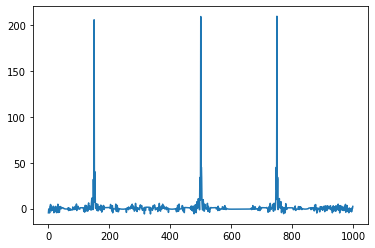

In [31]:
plt.plot(x1.detach().numpy())
